# Beyond the 3-Factor Model: Advanced Factor Investing

## Extensions, Anomalies, and the Cutting Edge of Asset Pricing Research

This notebook builds on the [Fama-French 3-Factor Tutorial](03_Fama_French_3Factor.ipynb). It assumes you understand regression mechanics, robust standard errors, and the original three factors (Mkt-RF, SMB, HML).

### What We'll Cover

1. **The Fama-French 5-Factor Model** — Adding profitability (RMW) and investment (CMA) factors, and the dividend discount model foundation
2. **The Carhart 4-Factor Model** — Momentum (UMD/WML)
3. **Novy-Marx Gross Profitability** — Why gross profitability predicts returns
4. **Short-Term Reversals & Mean Reversion** — Contrarian effects at different horizons
5. **The Beta Anomaly & Betting Against Beta** — Why CAPM beta fails empirically
6. **Recent Research** — Wei Dai, Andrew Chen & Zimmermann, Novy-Marx & Velikov, and more
7. **Practical Implications** — Dimensional Fund Advisors, Avantis, and the Rational Reminder perspective
8. **Hands-On Analysis** — Applying multi-factor models to SPY, IWN, and VTV

### Prerequisites

- Completed the [3-Factor Tutorial](03_Fama_French_3Factor.ipynb) (or equivalent knowledge)
- Comfortable with OLS regression, Newey-West standard errors, and factor model interpretation

### Quick Recap

In the 3-Factor tutorial we regressed SPY excess returns on Mkt-RF, SMB, and HML, applied Newey-West standard errors to account for heteroscedasticity and autocorrelation, and found that the market factor dominates SPY's variation while SMB and HML contribute modestly. That regression serves as our baseline throughout this notebook. Here, we ask: **can additional factors — profitability, investment, momentum, reversals — improve on the 3-factor specification, and what does the answer tell us about the cross-section of expected returns?**

In [3]:
# ============================================================================
# Setup: Import Libraries
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import yfinance as yf
import urllib.request
import zipfile
import tempfile
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# ============================================================================
# Download Fama-French Factor Data (3-Factor, 5-Factor, Momentum)
# ============================================================================

def download_ff_csv(zip_filename):
    """Download and parse a CSV from Kenneth French's data library.
    
    Handles varying header formats across different French data files
    by reading the raw file and finding where the numeric data begins.
    
    NOTE: The header detection heuristic (reading one line before the first
    YYYYMM row) works for all standard FF files used in this notebook
    (3-factor, 5-factor, momentum, ST/LT reversal). If you use this for
    other French files with unusual header layouts, you may need to adjust
    the skip logic.
    """
    url = f"https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/{zip_filename}"
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = f"{tmpdir}/data.zip"
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(tmpdir)
        files = [f for f in os.listdir(tmpdir) if f.lower().endswith('.csv')]
        if not files:
            raise ValueError(f"No CSV found in {zip_filename}")
        csv_path = f"{tmpdir}/{files[0]}"
        
        # Read raw lines to find where the monthly data starts
        import re
        with open(csv_path, 'r') as f:
            lines = f.readlines()
        
        # Find the first line that starts with a 6-digit YYYYMM date
        skip = 0
        for i, line in enumerate(lines):
            stripped = line.strip()
            if re.match(r'^\d{6}', stripped):
                skip = i
                break
        
        # Now find the header line (one line before the data)
        # Read from one line before data start to get column names
        header_line = skip - 1 if skip > 0 else 0
        df = pd.read_csv(csv_path, skiprows=header_line, index_col=0)
    
    df.index = pd.Index(df.index.astype(str).str.strip())
    df = df[df.index.str.match(r'^\d{6}$')]
    df.index = pd.to_datetime(df.index, format='%Y%m')
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    df = df / 100  # Convert percentages to decimals
    return df

# --- 3-Factor data ---
print("Downloading Fama-French 3-Factor data...")
ff3 = download_ff_csv("F-F_Research_Data_Factors_CSV.zip")
ff3.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

# --- 5-Factor data ---
print("Downloading Fama-French 5-Factor data...")
ff5 = download_ff_csv("F-F_Research_Data_5_Factors_2x3_CSV.zip")
ff5.columns = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# --- Momentum factor ---
print("Downloading Momentum factor (UMD)...")
mom = download_ff_csv("F-F_Momentum_Factor_CSV.zip")
mom.columns = ['UMD']

# --- Short-Term Reversal factor ---
print("Downloading Short-Term Reversal factor (ST_Rev)...")
st_rev = download_ff_csv("F-F_ST_Reversal_Factor_CSV.zip")
st_rev.columns = ['ST_Rev']

# --- Long-Term Reversal factor ---
print("Downloading Long-Term Reversal factor (LT_Rev)...")
lt_rev = download_ff_csv("F-F_LT_Reversal_Factor_CSV.zip")
lt_rev.columns = ['LT_Rev']

# Merge everything on the common date index
factors = ff5.copy()
factors = factors.join(mom, how='inner')
factors = factors.join(st_rev, how='inner')
factors = factors.join(lt_rev, how='inner')

# Filter to analysis period
factors = factors.loc['2000-01-01':'2023-12-31']

print(factors.head())
print(f"\nCombined factor dataset: {factors.shape[0]} months, {factors.shape[1]} columns")
print(f"Date range: {factors.index[0].date()} to {factors.index[-1].date()}")
print(f"Columns: {list(factors.columns)}")
print(f"\nFirst 5 rows:")

            Mkt_RF     SMB     HML     RMW     CMA      RF     UMD  ST_Rev  \
2000-01-01 -0.0474  0.0421 -0.0112 -0.0615  0.0456  0.0041  0.0186  0.0262   
2000-02-01  0.0245  0.1846 -0.0977 -0.1895 -0.0113  0.0043  0.1802 -0.1340   
2000-03-01  0.0521 -0.1554  0.0850  0.1165 -0.0120  0.0047 -0.0685  0.1009   
2000-04-01 -0.0635 -0.0475  0.0645  0.0807  0.0563  0.0046 -0.0860 -0.0208   
2000-05-01 -0.0439 -0.0386  0.0459  0.0405  0.0147  0.0050 -0.0899 -0.0883   

            LT_Rev  
2000-01-01  0.0162  
2000-02-01  0.0742  
2000-03-01 -0.0475  
2000-04-01  0.0026  
2000-05-01 -0.0189  

Combined factor dataset: 288 months, 9 columns
Date range: 2000-01-01 to 2023-12-01
Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'UMD', 'ST_Rev', 'LT_Rev']

First 5 rows:


In [5]:
# ============================================================================
# Download ETF Data (same three ETFs as the introductory notebook)
# ============================================================================

etf_tickers = {
    'SPY': 'SPY (S&P 500)',
    'IWN': 'IWN (Small Cap Value)',
    'VTV': 'VTV (Large Cap Value)',
}

print("Downloading ETF price data...\n")
etf_dataframes = {}

for ticker, label in etf_tickers.items():
    print(f"  Downloading {label}...")
    raw = yf.download(ticker, start='2000-01-01', end='2023-12-31', progress=False)

    if isinstance(raw.columns, pd.MultiIndex):
        try:
            close_price = raw[('Adj Close', ticker)]
        except KeyError:
            close_price = raw.iloc[:, 0]
    elif 'Adj Close' in raw.columns:
        close_price = raw['Adj Close']
    else:
        close_price = raw.iloc[:, 0]

    monthly = close_price.resample('MS').first()
    returns = monthly.pct_change().dropna()
    # Shift index back 1 month: pct_change at Feb 1 = Jan return,
    # but FF factors label Jan return at Jan 1
    returns.index = returns.index - pd.DateOffset(months=1)

    aligned = pd.Series(index=factors.index, dtype=float, data=np.nan)
    for date in returns.index:
        if date in aligned.index:
            aligned[date] = returns[date]
    aligned = aligned.dropna()

    rf = factors.loc[aligned.index, 'RF']
    excess = aligned - rf

    etf_df = factors.loc[aligned.index].copy()
    etf_df['Stock_Excess_Return'] = excess.values
    etf_dataframes[ticker] = etf_df
    print(f"    {len(etf_df)} months loaded")

# Find common period
common_idx = etf_dataframes['SPY'].index
for t in etf_tickers:
    common_idx = common_idx.intersection(etf_dataframes[t].index)
for t in etf_tickers:
    etf_dataframes[t] = etf_dataframes[t].loc[common_idx]

df = etf_dataframes['SPY'].copy()

print(f"\nCommon period: {common_idx[0].date()} to {common_idx[-1].date()}")
print(f"Months: {len(common_idx)}")
print(f"Primary analysis ETF: SPY")


    287 months loaded
    281 months loaded
    239 months loaded

Common period: 2004-01-01 to 2023-11-01
Months: 239
Primary analysis ETF: SPY


---

## Section 1: The Fama-French 5-Factor Model

### Key Definition: The Sharpe Ratio

Before we begin, one metric used frequently in this notebook is the **Sharpe ratio**, which measures risk-adjusted performance:

$$\text{Sharpe Ratio} = \frac{\bar{r}}{\sigma_r}$$

where $\bar{r}$ is the mean excess return (or factor return) and $\sigma_r$ is its standard deviation. A higher Sharpe ratio means better return per unit of risk. Typical values: 0.2–0.4 is moderate, >0.5 is strong, >1.0 is exceptional.

> **Note:** The Sharpe ratio is a *descriptive* statistic, not a hypothesis test. A Sharpe ratio of 0.6 is not automatically "statistically significant." To test whether a Sharpe ratio is significantly different from zero, you need a t-test on the mean excess return — which is exactly what the regression intercept (alpha) and its p-value provide. Throughout this notebook, we report Sharpe ratios to characterize factor premia but rely on Newey-West t-statistics for formal inference.

To annualize from monthly data: multiply the monthly Sharpe ratio by $\sqrt{12}$ (equivalently, use annualized mean and annualized volatility).

### A Note on the Sample Period

This notebook uses **2000–2023** data (vs. 2010–2023 in the introductory notebook). The longer sample is deliberate: the additional factors (especially momentum and reversals) exhibit dramatic regime changes (e.g., the 2009 momentum crash, value's 2018–2020 drawdown) that a shorter window would miss. The common ETF period will be limited by each ETF's inception date.

### From 3 Factors to 5

In 2015, Fama and French extended their original model by adding two new factors motivated by a growing body of evidence that profitability and investment patterns predict stock returns independently of size and value.

$$R_i(t) - R_f(t) = \alpha_i + \beta_{MKT}(R_m - R_f) + \beta_{SMB} \cdot SMB + \beta_{HML} \cdot HML + \beta_{RMW} \cdot RMW + \beta_{CMA} \cdot CMA + \epsilon_i(t)$$

### The Two New Factors

**RMW — Robust Minus Weak (Profitability)**
- Long stocks with **robust** (high) operating profitability, short stocks with **weak** (low) operating profitability
- Operating profitability = (Revenue − COGS − SGA − Interest Expense) / Book Equity
- Captures the empirical finding that profitable firms earn higher returns than unprofitable firms, controlling for other characteristics
- Average annual premium: roughly 3–4% historically (US data)

**CMA — Conservative Minus Aggressive (Investment)**
- Long stocks with **conservative** (low) asset growth, short stocks with **aggressive** (high) asset growth
- Investment = Change in total assets / lagged total assets
- Captures the finding that firms that invest aggressively tend to earn lower subsequent returns
- Average annual premium: roughly 2–3% historically

### Why Add These Factors?

Fama and French (2015) presented three motivations for augmenting the original model:

1. **Anomaly resolution.** Many CAPM/3-factor anomalies (e.g., the profitability and asset-growth effects) disappear once you control for RMW and CMA.

2. **Theoretical backing.** A simple dividend discount model shows that — holding price constant — a stock's expected return rises with expected profitability and falls with expected investment. This provides *ex ante* economic reasoning, not just empirical pattern-matching. **We develop this derivation in full detail below** — it is the theoretical heart of the five-factor model.

3. **HML becomes redundant.** In the 5-factor model, HML is largely spanned by the other four factors: its intercept (alpha) is near zero and statistically insignificant. This is one of the most debated results in modern asset pricing (see below).

### The HML Redundancy Debate

A striking result from Fama-French (2015): when you include RMW and CMA alongside the market and size factors, the time-series variation in HML is almost fully explained, and HML's alpha is close to zero.

**Why?** Value stocks tend to be:
- More profitable (positive RMW exposure)
- More conservative in their investment (positive CMA exposure)

So a portfolio that tilts toward profitability and low investment already captures much of what HML captures — the *value premium* may be a composite of profitability and investment effects.

**This does NOT mean value investing is dead.** It means:
- The *economic channels* through which value delivers returns are better understood: high book-to-market proxies for high expected profitability and conservative investment.
- Whether HML captures a distinct risk, or is merely a noisy proxy for RMW + CMA, remains actively debated. See Fama and French (2017) and Hou, Xue, and Zhang (2015) for opposing views.

### The Dividend Discount Model Foundation of FF5

The theoretical cornerstone of the five-factor model — and what distinguishes it from a purely empirical exercise — is a **dividend discount model (DDM)** derivation presented in Section I of Fama & French (2015). This is worth developing carefully, because it provides the *ex ante* economic logic for why profitability, investment, and book-to-market should predict returns.

#### The Clean-Surplus Valuation Identity

Start from the standard present-value relation. The market value of a stock's equity at time $t$ equals the discounted sum of expected future dividends:

$$M_t = \sum_{\tau=1}^{\infty} \frac{E_t(d_{t+\tau})}{(1+r)^\tau}$$

where $M_t$ is the market value of equity, $d_{t+\tau}$ are dividends paid at $t+\tau$, $r$ is the long-run average expected return (the discount rate, assumed constant for simplicity), and $E_t(\cdot)$ denotes expectations at time $t$.

Now invoke the **clean surplus accounting identity**: all changes in book equity come either from earnings or dividends (and net share issuance, which we fold into dividends for simplicity):

$$B_{t+1} = B_t + Y_{t+1} - d_{t+1}$$

where $B_t$ is book equity and $Y_{t+1}$ is total equity earnings in period $t+1$. Rearranging: $d_{t+1} = Y_{t+1} - \Delta B_{t+1}$, where $\Delta B_{t+1} = B_{t+1} - B_t$ is net **investment** in book equity.

Substituting into the DDM:

$$M_t = \sum_{\tau=1}^{\infty} \frac{E_t(Y_{t+\tau} - \Delta B_{t+\tau})}{(1+r)^\tau}$$

#### Dividing by Book Equity

Divide both sides by current book equity $B_t$:

$$\frac{M_t}{B_t} = \sum_{\tau=1}^{\infty} \frac{E_t\!\left(\frac{Y_{t+\tau}}{B_t} - \frac{\Delta B_{t+\tau}}{B_t}\right)}{(1+r)^\tau}$$

This is the equation that generates the five-factor model. The left-hand side is the **market-to-book ratio** (the inverse of book-to-market). The right-hand side depends on three things: expected profitability ($Y/B$), expected investment ($\Delta B/B$), and the discount rate ($r$) — which *is* the expected return.

#### The Three Comparative Statics

Now hold different variables fixed and see what happens to $r$:

| Holding fixed... | If this rises... | Then $r$ must... | Factor motivated |
|---|---|---|---|
| $M_t/B_t$ and $\Delta B/B$ (investment) | $Y/B$ (profitability) ↑ | **Rise** (to keep equation balanced) | **RMW** (profitable → higher expected returns) |
| $M_t/B_t$ and $Y/B$ (profitability) | $\Delta B/B$ (investment) ↑ | **Fall** (higher investment reduces numerator, so $r$ must be lower) | **CMA** (conservative investment → higher expected returns) |
| $Y/B$ and $\Delta B/B$ | $B_t/M_t$ (book-to-market) ↑ | **Rise** (lower price for same cash flows → higher discount rate) | **HML** (value → higher expected returns) |

This is the key result. **All three cross-sectional patterns — the value effect, the profitability effect, and the investment effect — follow from a single valuation equation.** The DDM doesn't tell us *why* discount rates vary across stocks (risk? mispricing?), but it tells us that *if* discount rates vary, these are exactly the observable characteristics that should predict returns.

#### Why This Matters

1. **Theoretical coherence.** The CAPM derives expected returns from a single risk factor. FF3 was largely empirical — Fama and French acknowledged in 1993 that their factors "may or may not be risk factors." The DDM derivation gives FF5 a value-theoretic foundation: the factors are not arbitrary; they map onto the primitives of the valuation equation.

2. **HML redundancy explained.** The DDM shows that book-to-market captures a *combination* of profitability and investment information. Once you control for profitability (RMW) and investment (CMA) directly, book-to-market has little independent information left — explaining the famous HML redundancy result.

3. **It applies to *any* theory of discount rates.** Whether you think expected return variation is driven by rational risk compensation (efficient markets) or systematic mispricing (behavioral finance), the DDM comparative statics hold. The equation is an accounting identity combined with present-value logic — it's agnostic about *why* $r$ varies.

4. **Connection to the q-factor model.** Hou, Xue, and Zhang's (2015) q-factor model arrives at similar factors from **production-based** asset pricing (firms' investment Euler equations). The fact that two very different theoretical starting points — demand-side valuation (DDM) and supply-side production theory — both point to profitability and investment as key state variables is powerful evidence that these factors capture something fundamental.

> **Fama & French (2015), p. 2:** *"The motivation for the five-factor model is the dividend discount model... If the model's description of expected returns is complete, the intercept $a_i$ is zero for all assets."*

#### Limitations of the DDM Motivation

The derivation is not without caveats:

- **Constant discount rates.** The DDM derivation assumes a single constant $r$. In reality, discount rates are time-varying. Lettau and Wachter (2007) and others have explored how time-varying discount rates complicate the clean mapping from characteristics to expected returns.
- **Clean surplus violations.** In practice, accounting doesn't perfectly satisfy the clean surplus relation (e.g., comprehensive income items bypass the income statement). This adds noise but doesn't invalidate the qualitative predictions.
- **The model is silent on momentum.** The DDM naturally motivates value, profitability, and investment — but not momentum. This is one reason Fama and French excluded momentum from FF5: it lacks a clean valuation-theoretic justification, sitting uncomfortably between behavioral and risk-based explanations.
- **Expectations vs. realizations.** The DDM involves *expected* future profitability and investment. We observe only *realized* (past) values. The implicit assumption is that past profitability and investment are reasonable proxies for expectations — reasonable but imperfect.

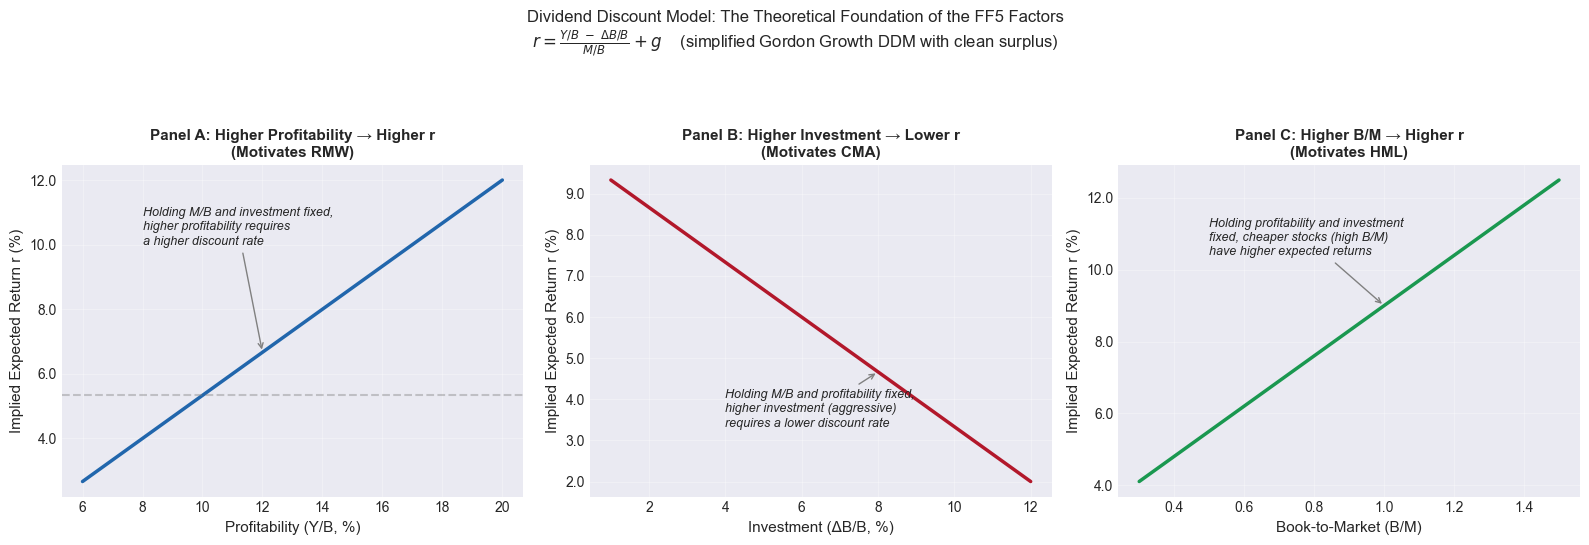

DDM COMPARATIVE STATICS — NUMERICAL EXAMPLE

Baseline: Y/B = 12%,  ΔB/B = 5%,  M/B = 1.5,  g = 2%
  → Implied expected return: 6.67%

Scenario                                  Y/B   ΔB/B    M/B        r
----------------------------------------------------------------------
High profitability (Y/B = 18%)           18%    5%    1.5  10.67% ↑ (+4.00%)
Low profitability  (Y/B = 6%)             6%    5%    1.5   2.67% ↓ (-4.00%)
Conservative inv.  (ΔB/B = 2%)           12%    2%    1.5   8.67% ↑ (+2.00%)
Aggressive inv.    (ΔB/B = 10%)          12%   10%    1.5   3.33% ↓ (-3.33%)
Deep value stock   (M/B = 0.8)           12%    5%    0.8  10.75% ↑ (+4.08%)
Growth stock       (M/B = 3.0)           12%    5%    3.0   4.33% ↓ (-2.33%)

→ These are exactly the cross-sectional patterns that RMW, CMA, and HML capture.
  The DDM shows they are not ad hoc — they follow from present-value logic.


In [7]:
# ============================================================================
# DDM Illustration: How Profitability, Investment, and B/M Map to Expected Returns
# ============================================================================
# This cell provides a numerical illustration of the Fama-French (2015) DDM
# comparative statics. We solve for the implied discount rate (expected return)
# under different assumptions about profitability and investment growth.
#
# The simplified DDM (Gordon Growth variant with clean surplus):
#   M = (Y - dB) / (r - g)   =>   r = (Y - dB)/M + g
# where Y = earnings, dB = net investment, M = market value, g = growth rate.
# Equivalently, dividing by book equity B:
#   M/B = (Y/B - dB/B) / (r - g)
# so:
#   r = (Y/B - dB/B) / (M/B) + g

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Parameters ---
growth_rate = 0.02          # long-run nominal growth rate (g)
profitability_range = np.linspace(0.06, 0.20, 100)  # Y/B: ROE from 6% to 20%
investment_range = np.linspace(0.01, 0.12, 100)      # dB/B: reinvestment rate

# Fix one dimension and vary the other to show comparative statics

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- Panel A: Expected return vs. Profitability (Y/B) ---
# Fix: M/B = 1.5,  dB/B = 0.05
mb_fixed = 1.5
inv_fixed = 0.05
r_vs_prof = (profitability_range - inv_fixed) / mb_fixed + growth_rate

ax = axes[0]
ax.plot(profitability_range * 100, r_vs_prof * 100, color='#2166ac', linewidth=2.5)
ax.set_xlabel('Profitability (Y/B, %)', fontsize=11)
ax.set_ylabel('Implied Expected Return r (%)', fontsize=11)
ax.set_title('Panel A: Higher Profitability → Higher r\n(Motivates RMW)', fontsize=11, fontweight='bold')
ax.axhline(y=(0.10 - inv_fixed) / mb_fixed * 100 + growth_rate * 100, color='gray',
           linestyle='--', alpha=0.4)
ax.annotate('Holding M/B and investment fixed,\nhigher profitability requires\na higher discount rate',
            xy=(0.12 * 100, ((0.12 - inv_fixed) / mb_fixed + growth_rate) * 100),
            xytext=(0.08 * 100, ((0.17 - inv_fixed) / mb_fixed + growth_rate) * 100),
            fontsize=9, fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.grid(True, alpha=0.3)

# --- Panel B: Expected return vs. Investment (dB/B) ---
# Fix: M/B = 1.5,  Y/B = 0.12
prof_fixed = 0.12
r_vs_inv = (prof_fixed - investment_range) / mb_fixed + growth_rate

ax = axes[1]
ax.plot(investment_range * 100, r_vs_inv * 100, color='#b2182b', linewidth=2.5)
ax.set_xlabel('Investment (ΔB/B, %)', fontsize=11)
ax.set_ylabel('Implied Expected Return r (%)', fontsize=11)
ax.set_title('Panel B: Higher Investment → Lower r\n(Motivates CMA)', fontsize=11, fontweight='bold')
ax.annotate('Holding M/B and profitability fixed,\nhigher investment (aggressive)\nrequires a lower discount rate',
            xy=(0.08 * 100, ((prof_fixed - 0.08) / mb_fixed + growth_rate) * 100),
            xytext=(0.04 * 100, ((prof_fixed - 0.10) / mb_fixed + growth_rate) * 100),
            fontsize=9, fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.grid(True, alpha=0.3)

# --- Panel C: Expected return vs. B/M (inverse of M/B) ---
# Fix: Y/B = 0.12,  dB/B = 0.05
bm_range = np.linspace(0.3, 1.5, 100)   # B/M from 0.3 (growth) to 1.5 (deep value)
mb_range = 1.0 / bm_range
r_vs_bm = (prof_fixed - inv_fixed) / mb_range + growth_rate

ax = axes[2]
ax.plot(bm_range, r_vs_bm * 100, color='#1a9850', linewidth=2.5)
ax.set_xlabel('Book-to-Market (B/M)', fontsize=11)
ax.set_ylabel('Implied Expected Return r (%)', fontsize=11)
ax.set_title('Panel C: Higher B/M → Higher r\n(Motivates HML)', fontsize=11, fontweight='bold')
ax.annotate('Holding profitability and investment\nfixed, cheaper stocks (high B/M)\nhave higher expected returns',
            xy=(1.0, ((prof_fixed - inv_fixed) * 1.0 + growth_rate) * 100),
            xytext=(0.5, ((prof_fixed - inv_fixed) * 1.2 + growth_rate) * 100),
            fontsize=9, fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.grid(True, alpha=0.3)

plt.suptitle('Dividend Discount Model: The Theoretical Foundation of the FF5 Factors\n'
             r'$r = \frac{Y/B\ -\ \Delta B/B}{M/B} + g$' + '    (simplified Gordon Growth DDM with clean surplus)',
             fontsize=12, y=1.08)
plt.tight_layout()
plt.show()

# --- Summary table ---
print("=" * 70)
print("DDM COMPARATIVE STATICS — NUMERICAL EXAMPLE")
print("=" * 70)
print(f"\nBaseline: Y/B = 12%,  ΔB/B = 5%,  M/B = 1.5,  g = 2%")
baseline_r = (0.12 - 0.05) / 1.5 + 0.02
print(f"  → Implied expected return: {baseline_r:.2%}\n")

scenarios = [
    ("High profitability (Y/B = 18%)",  0.18, 0.05, 1.5),
    ("Low profitability  (Y/B = 6%)",   0.06, 0.05, 1.5),
    ("Conservative inv.  (ΔB/B = 2%)",  0.12, 0.02, 1.5),
    ("Aggressive inv.    (ΔB/B = 10%)", 0.12, 0.10, 1.5),
    ("Deep value stock   (M/B = 0.8)",  0.12, 0.05, 0.8),
    ("Growth stock       (M/B = 3.0)",  0.12, 0.05, 3.0),
]

print(f"{'Scenario':<38} {'Y/B':>6} {'ΔB/B':>6} {'M/B':>6} {'r':>8}")
print("-" * 70)
for label, yb, db, mb in scenarios:
    r = (yb - db) / mb + growth_rate
    delta = r - baseline_r
    arrow = "↑" if delta > 0 else "↓"
    print(f"{label:<38} {yb:>5.0%} {db:>5.0%} {mb:>6.1f} {r:>7.2%} {arrow} ({delta:+.2%})")

print("\n→ These are exactly the cross-sectional patterns that RMW, CMA, and HML capture.")
print("  The DDM shows they are not ad hoc — they follow from present-value logic.")

In [ ]:
# ============================================================================
# 5-Factor Model: Factor Summary Statistics
# ============================================================================

print("="*70)
print("FAMA-FRENCH 5-FACTOR SUMMARY STATISTICS (2000–2023)")
print("="*70)

factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_stats = factors[factor_cols].describe().T
factor_stats['Annualized Mean'] = factors[factor_cols].mean() * 12
factor_stats['Annualized Std'] = factors[factor_cols].std() * np.sqrt(12)
factor_stats['Sharpe Ratio'] = factor_stats['Annualized Mean'] / factor_stats['Annualized Std']
factor_stats['t-stat (mean=0)'] = (factors[factor_cols].mean() / 
                                    (factors[factor_cols].std() / np.sqrt(len(factors))))

print("\nMonthly Statistics:")
print(factors[factor_cols].describe().round(4))

print("\n\nAnnualized Performance:")
print(factor_stats[['Annualized Mean', 'Annualized Std', 'Sharpe Ratio', 't-stat (mean=0)']].round(4))

print("""
INTERPRETATION:
- Mkt_RF has the highest average premium but also the highest volatility
- RMW (profitability) has had a strong, relatively stable premium
- CMA (investment) has a positive but typically smaller premium
- HML (value) has had a mixed record since 2000 (value struggled 2018-2020)
- SMB (size) has been the weakest factor in this sample period
""")

In [ ]:
# ============================================================================
# Visualize: Factor risk-return profile
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']
ann_means = factors[factor_cols].mean() * 12
ann_stds = factors[factor_cols].std() * np.sqrt(12)
sharpes = ann_means / ann_stds

colors = {'Mkt_RF': '#2c3e50', 'SMB': '#e74c3c', 'HML': '#2ecc71',
          'RMW': '#3498db', 'CMA': '#9b59b6'}

# --- Left: Risk-return scatter ---
ax = axes[0]
for col in factor_cols:
    ax.scatter(ann_stds[col], ann_means[col], s=120, color=colors[col],
               edgecolors='white', linewidth=1.5, zorder=3)
    ax.annotate(col, (ann_stds[col], ann_means[col]),
                textcoords="offset points", xytext=(8, 5), fontsize=10, fontweight='bold',
                color=colors[col])
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Annualized Volatility', fontsize=11)
ax.set_ylabel('Annualized Mean Return', fontsize=11)
ax.set_title('Factor Risk-Return Profile', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3)

# --- Right: Sharpe ratio bar chart ---
ax2 = axes[1]
bar_colors = [colors[col] for col in factor_cols]
bars = ax2.bar(factor_cols, sharpes, color=bar_colors, edgecolor='white', width=0.55)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
for bar, sr in zip(bars, sharpes):
    ax2.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.01 if sr >= 0 else -0.04),
             f'{sr:.2f}', ha='center', fontsize=10, fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontsize=11)
ax2.set_title('Factor Sharpe Ratios (Annualized)', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('Fama-French 5-Factor Performance Overview', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 5-Factor Model: Factor Correlation Matrix
# ============================================================================

print("FACTOR CORRELATION MATRIX")
print("="*70)

corr = factors[factor_cols].corr()
print(corr.round(3))

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            mask=mask, square=True, ax=ax, vmin=-1, vmax=1,
            linewidths=0.5)
ax.set_title('Factor Correlation Matrix (2000–2023)', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('factor_correlations.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY OBSERVATIONS:
- HML and CMA are strongly positively correlated — value stocks tend to be 
  conservative investors. This is why CMA partially "explains" HML.
- RMW and HML are often negatively correlated — cheap (value) stocks tend to 
  be less profitable. This creates tension in the model.
- SMB has low correlation with the other factors — size captures something distinct.
- Mkt_RF is relatively independent of the style factors — by construction.
""")

In [ ]:
# ============================================================================
# 5-Factor Regression: Compare 3-Factor vs 5-Factor for all ETFs
# ============================================================================

def run_ff_regression(y, X_cols, data, model_name="Model", stock_name="Stock"):
    """Run a factor regression with Newey-West standard errors.
    
    All regressions in this notebook use Newey-West HAC standard errors,
    as justified in the introductory notebook (Section 9). This accounts
    for heteroscedasticity and autocorrelation in financial time-series
    without requiring separate diagnostic checks for each regression.
    
    Why Newey-West?  Financial returns are neither homoscedastic (volatility
    clusters in time) nor serially independent (monthly residuals exhibit
    mild autocorrelation).  Classic OLS standard errors would therefore be
    too small, inflating t-statistics and producing overly optimistic p-values.
    Newey-West corrects for *both* problems at once by estimating the
    'sandwich' covariance matrix with Bartlett-weighted cross-lag terms.
    For the full derivation and a hand-checkable example, see the
    Statistical Foundations Tutorial (Sections 7-10).
    
    Lag length is set by the Andrews (1991) rule: L = floor(4*(n/100)^(2/9)).
    """
    y_vals = data['Stock_Excess_Return'].values
    X_vals = sm.add_constant(data[X_cols].values)
    model = sm.OLS(y_vals, X_vals)
    results = model.fit()
    n = len(y_vals)
    lag = int(np.floor(4 * (n / 100) ** (2/9)))
    results_nw = results.get_robustcov_results(cov_type='HAC', maxlags=lag)
    return results_nw

print("="*70)
print("3-FACTOR vs 5-FACTOR MODEL COMPARISON")
print("="*70)

comparison_data = []

for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]

    # 3-Factor
    res3 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML'], edf,
                              model_name="FF3", stock_name=label)
    # 5-Factor
    res5 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'], edf,
                              model_name="FF5", stock_name=label)

    comparison_data.append({
        'ETF': ticker,
        'FF3 R²': res3.rsquared,
        'FF5 R²': res5.rsquared,
        'FF3 Adj R²': res3.rsquared_adj,
        'FF5 Adj R²': res5.rsquared_adj,
        'FF3 Alpha': res3.params[0],
        'FF5 Alpha': res5.params[0],
        'FF3 Alpha p': res3.pvalues[0],
        'FF5 Alpha p': res5.pvalues[0],
    })

    print(f"\n{'='*70}")
    print(f"  {label}")
    print(f"{'='*70}")
    print(f"\n  3-Factor Model:")
    print(f"    Alpha = {res3.params[0]:.6f}  (p = {res3.pvalues[0]:.4f})")
    print(f"    Mkt   = {res3.params[1]:.4f}  SMB = {res3.params[2]:.4f}  HML = {res3.params[3]:.4f}")
    print(f"    R² = {res3.rsquared:.4f}   Adj R² = {res3.rsquared_adj:.4f}")
    print(f"\n  5-Factor Model:")
    print(f"    Alpha = {res5.params[0]:.6f}  (p = {res5.pvalues[0]:.4f})")
    print(f"    Mkt   = {res5.params[1]:.4f}  SMB = {res5.params[2]:.4f}  HML = {res5.params[3]:.4f}")
    print(f"    RMW   = {res5.params[4]:.4f}  CMA = {res5.params[5]:.4f}")
    print(f"    R² = {res5.rsquared:.4f}   Adj R² = {res5.rsquared_adj:.4f}")
    print(f"\n    R² improvement: {res5.rsquared - res3.rsquared:+.4f}")

comp_df = pd.DataFrame(comparison_data)
print("\n\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(comp_df.to_string(index=False, float_format='%.4f'))

In [ ]:
# ============================================================================
# Visualize: 3-Factor vs 5-Factor model comparison
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

tickers = list(etf_tickers.keys())
labels = [etf_tickers[t] for t in tickers]
short_labels = tickers

# Re-extract coefficients for plotting
coef_data_3f = {}
coef_data_5f = {}
for ticker in tickers:
    edf = etf_dataframes[ticker]
    res3 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML'], edf)
    res5 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'], edf)
    coef_data_3f[ticker] = {'Alpha': res3.params[0], 'Mkt_RF': res3.params[1],
                             'SMB': res3.params[2], 'HML': res3.params[3],
                             'R²': res3.rsquared}
    coef_data_5f[ticker] = {'Alpha': res5.params[0], 'Mkt_RF': res5.params[1],
                             'SMB': res5.params[2], 'HML': res5.params[3],
                             'RMW': res5.params[4], 'CMA': res5.params[5],
                             'R²': res5.rsquared}

# --- Left: R² comparison ---
ax = axes[0]
x_pos = np.arange(len(tickers))
width = 0.3
bars1 = ax.bar(x_pos - width/2, [coef_data_3f[t]['R²'] for t in tickers],
               width, label='3-Factor', color='#3498db', edgecolor='white')
bars2 = ax.bar(x_pos + width/2, [coef_data_5f[t]['R²'] for t in tickers],
               width, label='5-Factor', color='#e67e22', edgecolor='white')
for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{bar.get_height():.3f}', ha='center', fontsize=9, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(short_labels, fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title('Model Fit: 3-Factor vs 5-Factor', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.08)

# --- Right: Coefficient comparison for shared factors ---
ax2 = axes[1]
shared_factors = ['Mkt_RF', 'SMB', 'HML']
x_pos2 = np.arange(len(shared_factors))
group_width = 0.8
bar_w = group_width / len(tickers) / 2  # 2 models per ticker

color_3f = ['#3498db', '#2980b9', '#1a5276']
color_5f = ['#e67e22', '#d35400', '#a04000']

for i, ticker in enumerate(tickers):
    offset_3f = -group_width/2 + i * (group_width/len(tickers)) + bar_w * 0.1
    offset_5f = offset_3f + bar_w
    vals_3f = [coef_data_3f[ticker][f] for f in shared_factors]
    vals_5f = [coef_data_5f[ticker][f] for f in shared_factors]
    ax2.bar(x_pos2 + offset_3f, vals_3f, bar_w * 0.9, color=color_3f[i], alpha=0.7,
            label=f'{ticker} (3F)' if i == 0 else f'{ticker} (3F)')
    ax2.bar(x_pos2 + offset_5f, vals_5f, bar_w * 0.9, color=color_5f[i], alpha=0.7,
            label=f'{ticker} (5F)' if i == 0 else f'{ticker} (5F)')

ax2.set_xticks(x_pos2)
ax2.set_xticklabels(shared_factors, fontsize=11)
ax2.set_ylabel('Coefficient', fontsize=11)
ax2.set_title('How Betas Change: 3F → 5F', fontweight='bold', fontsize=13)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax2.legend(fontsize=7, ncol=3, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('3-Factor vs 5-Factor Model Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("NOTE: Watch how HML betas change when RMW and CMA are added — this is the")
print("'HML is redundant' effect Fama and French (2015) documented.")

### Interpreting the 3-Factor vs 5-Factor Comparison

**What to look for:**

1. **R² improvement**: The 5-factor model should explain at least as much variance as the 3-factor model. For broad-market ETFs like SPY, the improvement may be modest since the market factor dominates. For style ETFs like IWN (small value) or VTV (large value), the additional factors may capture meaningful variation.

2. **Alpha changes**: If alpha shrinks when moving from 3 to 5 factors, the "outperformance" was actually compensation for profitability/investment factor exposures — not genuine skill.

3. **RMW and CMA loadings**:
   - IWN (small cap value) may show **negative RMW** — small value firms are often less profitable
   - VTV (large cap value) may show **positive RMW** — large value firms tend to be more profitable
   - Both value ETFs should show **positive CMA** — value stocks tend to be conservative investors

4. **HML coefficient changes**: Watch how β_HML changes between the 3- and 5-factor specifications. Due to the high correlation between HML and CMA, the HML loading may shrink when CMA is included.

---

## Section 2: Momentum — The Carhart 4-Factor Model

### The Premier Anomaly

Momentum is one of the most robust and persistent anomalies in finance. First documented formally by Jegadeesh and Titman (1993), it refers to the tendency of stocks that have performed well over the past 3–12 months to continue performing well, and vice versa.

### The Carhart (1997) 4-Factor Model

Mark Carhart extended the Fama-French 3-factor model by adding a momentum factor:

$$R_i - R_f = \alpha + \beta_{MKT}(R_m - R_f) + \beta_{SMB} \cdot SMB + \beta_{HML} \cdot HML + \beta_{UMD} \cdot UMD + \epsilon$$

**UMD (Up Minus Down)**, also called **WML (Winners Minus Losers)**:
- Long stocks with high returns over months $t-12$ to $t-2$
- Short stocks with low returns over the same period
- Month $t-1$ is skipped to avoid the short-term reversal effect (more on this later)
- Average annual premium: roughly 6–8% historically — **larger than value or size**

### Why Does Momentum Exist?

This is one of the great debates in finance:

**Behavioral Explanations:**
- **Underreaction**: Investors are slow to incorporate new information → prices drift in the direction of news
- **Overconfidence + Self-attribution bias**: When investors' picks go up, they attribute it to their skill and buy more; when picks go down, they blame bad luck
- **Herding**: Investors follow trends, creating self-reinforcing price movements
- **Disposition effect**: Investors sell winners too early and hold losers too long, creating persistent price trends

**Risk-Based Explanations:**
- Momentum stocks are riskier because they have **crash risk** — momentum strategies experience rare but devastating drawdowns (e.g., 2009 momentum crash: −73% in a few months)
- Time-varying risk: momentum profits may compensate for loading on a latent risk factor during economic state changes
- However, no fully satisfactory risk-based explanation has been widely accepted

**Fama and French's Position:**
- Fama and French deliberately excluded momentum from their 5-factor model
- In their 2015 paper, they acknowledged momentum's existence but argued it is not a "pervasive" risk factor in the same way as their other factors — it's more of a trading strategy than a source of systematic risk
- They note that momentum **does not have a clear risk-based story**, which is uncomfortable from an efficient markets perspective

### Momentum Crashes

A critical feature of momentum is its **left tail risk**. Daniel and Moskowitz (2016) documented that momentum experiences severe crashes, particularly after market downturns when previously losing stocks (now cheap) rapidly rebound:

- **2009**: The momentum factor lost roughly 73% in a few months as value stocks rebounded after the financial crisis
- **1932**: Similar crash after the Great Depression
- These crashes tend to occur when the market recovers sharply from a bear market — exactly when past losers (beaten-down stocks) surge

In [ ]:
# ============================================================================
# Momentum Factor Analysis
# ============================================================================

print("="*70)
print("MOMENTUM FACTOR (UMD) ANALYSIS")
print("="*70)

# Cumulative returns of all factors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative factor returns
ax = axes[0, 0]
for col, color, lbl in [('Mkt_RF', 'darkblue', 'Market'),
                          ('SMB', 'teal', 'SMB (Size)'),
                          ('HML', 'purple', 'HML (Value)'),
                          ('RMW', 'darkgreen', 'RMW (Profit.)'),
                          ('CMA', 'brown', 'CMA (Invest.)'),
                          ('UMD', 'red', 'UMD (Momentum)')]:
    cum = (1 + factors[col]).cumprod()
    ax.plot(factors.index, cum, label=lbl, linewidth=1.5, color=color)
ax.set_title('Cumulative Factor Returns (2000–2023)', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=8, loc='upper left')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 2: Momentum monthly returns
ax = axes[0, 1]
ax.bar(factors.index, factors['UMD'] * 100, color='red', alpha=0.6, width=25)
ax.set_title('Monthly Momentum Returns (UMD)', fontweight='bold')
ax.set_ylabel('Return (%)')
ax.grid(True, alpha=0.3)

# Plot 3: Rolling 12-month momentum return
ax = axes[1, 0]
rolling_mom = factors['UMD'].rolling(12).sum() * 100
ax.plot(factors.index, rolling_mom, color='red', linewidth=1.5)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.fill_between(factors.index, rolling_mom, 0,
                where=rolling_mom < 0, color='red', alpha=0.3, label='Drawdown periods')
ax.set_title('Rolling 12-Month Momentum Return', fontweight='bold')
ax.set_ylabel('Cumulative 12M Return (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Distribution of momentum returns vs market
ax = axes[1, 1]
ax.hist(factors['UMD'] * 100, bins=40, alpha=0.6, color='red', label='UMD', density=True)
ax.hist(factors['Mkt_RF'] * 100, bins=40, alpha=0.4, color='blue', label='Mkt-RF', density=True)
ax.set_title('Distribution: Momentum vs Market', fontweight='bold')
ax.set_xlabel('Monthly Return (%)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('momentum_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

# Momentum statistics
print(f"\nMomentum (UMD) Summary Statistics:")
print(f"  Mean monthly return:    {factors['UMD'].mean()*100:.2f}%")
print(f"  Monthly std dev:        {factors['UMD'].std()*100:.2f}%")
print(f"  Annualized return:      {factors['UMD'].mean()*1200:.2f}%")
print(f"  Annualized volatility:  {factors['UMD'].std()*np.sqrt(12)*100:.2f}%")
print(f"  Sharpe ratio:           {factors['UMD'].mean()/factors['UMD'].std()*np.sqrt(12):.2f}")
print(f"  Skewness:               {factors['UMD'].skew():.2f}")
print(f"  Kurtosis:               {factors['UMD'].kurtosis():.2f}")
print(f"  Worst month:            {factors['UMD'].min()*100:.2f}%")
print(f"  Best month:             {factors['UMD'].max()*100:.2f}%")

print(f"""
OBSERVATIONS:
- Momentum has high average returns but LARGE NEGATIVE SKEWNESS
- The worst month is extremely negative — this is the momentum crash risk
- The distribution has fat tails (high kurtosis) compared to the market
- This crash risk is a key reason momentum is hard to capture in practice
""")

In [ ]:
# ============================================================================
# Carhart 4-Factor Model: Regression for all ETFs
# ============================================================================

print("="*70)
print("CARHART 4-FACTOR MODEL (FF3 + MOMENTUM)")
print("="*70)

carhart_cols = ['Mkt_RF', 'SMB', 'HML', 'UMD']

for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]
    res4 = run_ff_regression(None, carhart_cols, edf, stock_name=label)

    print(f"\n{label}")
    print("-" * 50)
    names = ['Alpha', 'Mkt_RF', 'SMB', 'HML', 'UMD']
    for i, name in enumerate(names):
        sig = '***' if res4.pvalues[i] < 0.01 else ('**' if res4.pvalues[i] < 0.05 else ('*' if res4.pvalues[i] < 0.10 else ''))
        print(f"  {name:10s} = {res4.params[i]:8.4f}  (t = {res4.tvalues[i]:6.2f}, p = {res4.pvalues[i]:.4f}) {sig}")
    print(f"  R² = {res4.rsquared:.4f}   Adj R² = {res4.rsquared_adj:.4f}")

print(f"""
INTERPRETATION:
- SPY: UMD loading should be near zero — the S&P 500 has no systematic 
  momentum tilt (it holds both winners and losers).

- IWN (Small Value): May show near-zero or slightly negative UMD loading —
  value stocks are often past losers (i.e., anti-momentum).

- VTV (Large Value): Similar to IWN but the anti-momentum effect may be 
  weaker since large-cap stocks exhibit less extreme reversal tendencies.

KEY INSIGHT: Value and momentum are negatively correlated strategies.
Stocks that are cheap (value) have often had poor past returns (anti-momentum).
This negative correlation makes them excellent diversifiers when combined.
""")

---

## Section 3: Profitability — Novy-Marx and Beyond

### Gross Profitability: The "Other Side of Value"

Robert Novy-Marx (2013) published one of the most influential papers in modern empirical asset pricing: *"The Other Side of Value: The Gross Profitability Premium."* His key finding:

> **Gross profitability** (Revenue − COGS) / Total Assets is the best single predictor of future stock returns among profitability measures, and its predictive power is comparable in magnitude to the value factor.

### Why Gross Profitability?

Novy-Marx argued that gross profit (revenue minus cost of goods sold) is a cleaner measure of economic profitability than operating or net income because:

1. **Less susceptible to accounting manipulation** — Items further down the income statement (SGA, depreciation, special items) are more discretionary
2. **Better captures "productive assets"** — It measures the efficiency of a firm's core operations before overhead and financing decisions
3. **Controls for growth options** — Firms with high gross profitability have valuable assets-in-place, and including lower-level expenses adds noise

### The Value–Profitability Interaction

The most surprising result: **gross profitability and value (book-to-market) are negatively correlated** but both independently predict returns. This has profound implications:

- Controlling for value, profitable stocks earn higher returns
- Controlling for profitability, value stocks earn higher returns
- **Combined** value + profitability strategies significantly outperform either alone
- This is why Dimensional Fund Advisors (and later Avantis) emphasize both dimensions

### Fama-French RMW vs. Novy-Marx GP/A

The Fama-French RMW factor uses **operating profitability** (a broader measure), while Novy-Marx advocated for **gross profitability** (GP/A). The two are related but not identical:

| Measure | Definition | Novy-Marx (2013) | Fama-French (2015) |
|---------|-----------|-----------------|-------------------|
| **Gross Profitability** | (Revenue − COGS) / Assets | ✓ Primary measure | |
| **Operating Profitability** | (Revenue − COGS − SGA − Interest) / Book Equity | | ✓ Used for RMW |

Both capture the profitability premium, but the exact measure matters. Recent research (Ball et al., 2015, 2016) showed that operating profitability may actually be slightly better than gross profitability when defined relative to book equity — partly reconciling the two approaches.

### Profitability: Risk or Mispricing?

**Risk-based view** (Fama-French perspective):
- Profitable firms are riskier because their cash flows are more sensitive to economic conditions
- High profitability implies high expected returns as compensation for this risk

**Mispricing view**:
- Investors undervalue profitable firms because they focus too much on price multiples
- The market is slow to recognize that high profitability is persistent

**Novy-Marx's argument**: The profitability premium is "too clean" to be mispricing — it works in every size group, in international markets, and persists after transaction costs. This favors a risk-based view, though the debate continues.

In [ ]:
# ============================================================================
# Profitability Factor Deep Dive
# ============================================================================

print("="*70)
print("PROFITABILITY FACTOR (RMW) DEEP DIVE")
print("="*70)

# RMW statistics
rmw = factors['RMW']
print(f"\nRMW (Robust Minus Weak) Summary:")
print(f"  Mean monthly:       {rmw.mean()*100:.2f}%")
print(f"  Annualized return:  {rmw.mean()*1200:.2f}%")
print(f"  Ann. volatility:    {rmw.std()*np.sqrt(12)*100:.2f}%")
print(f"  Sharpe ratio:       {rmw.mean()/rmw.std()*np.sqrt(12):.2f}")
print(f"  t-stat (mean=0):    {rmw.mean()/(rmw.std()/np.sqrt(len(rmw))):.2f}")
print(f"  Skewness:           {rmw.skew():.2f}")
print(f"  Correlation w/ HML: {factors['RMW'].corr(factors['HML']):.3f}")
print(f"  Correlation w/ UMD: {factors['RMW'].corr(factors['UMD']):.3f}")

# Interaction: Value × Profitability
# Show that HML and RMW are negatively correlated but both have positive premia
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: RMW vs HML scatter
ax = axes[0]
ax.scatter(factors['HML'] * 100, factors['RMW'] * 100, alpha=0.4, s=30)
z = np.polyfit(factors['HML'], factors['RMW'], 1)
p = np.poly1d(z)
x_range = np.linspace(factors['HML'].min(), factors['HML'].max(), 100)
ax.plot(x_range * 100, p(x_range) * 100, 'r-', linewidth=2)
ax.set_xlabel('HML Return (%)')
ax.set_ylabel('RMW Return (%)')
ax.set_title('Value vs Profitability\n(Negative correlation = diversification)', fontweight='bold')
ax.grid(True, alpha=0.3)
corr_val = factors['HML'].corr(factors['RMW'])
ax.annotate(f'r = {corr_val:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=12, fontweight='bold', va='top')

# Plot 2: Cumulative returns of HML, RMW, and combined
ax = axes[1]
combined = (factors['HML'] + factors['RMW']) / 2  # Equal-weight combination
cum_hml = (1 + factors['HML']).cumprod()
cum_rmw = (1 + factors['RMW']).cumprod()
cum_combined = (1 + combined).cumprod()
ax.plot(factors.index, cum_hml, label='HML (Value)', color='purple', linewidth=1.5)
ax.plot(factors.index, cum_rmw, label='RMW (Profitability)', color='darkgreen', linewidth=1.5)
ax.plot(factors.index, cum_combined, label='50/50 Blend', color='black', linewidth=2, linestyle='--')
ax.set_title('Cumulative Returns:\nValue, Profitability, and Blend', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Rolling correlation between HML and RMW
ax = axes[2]
rolling_corr = factors['HML'].rolling(36).corr(factors['RMW'])
ax.plot(factors.index, rolling_corr, color='darkred', linewidth=1.5)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('Rolling 36-Month Correlation\nHML vs RMW', fontweight='bold')
ax.set_ylabel('Correlation')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('profitability_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY TAKEAWAYS:
1. Value (HML) and Profitability (RMW) have a time-varying correlation — 
   positive in the full sample, but with extended negative periods (see the 
   rolling correlation plot). This means they can diversify each other.
   
2. The 50/50 blend is smoother than either factor alone — this is the 
   diversification benefit that Dimensional and Avantis exploit.
   
3. At the STOCK level, value and profitability are negatively correlated:
   cheap stocks tend to be less profitable. But screening for BOTH (cheap 
   AND profitable) captures both premia simultaneously.
""")

---

## Section 4: Short-Term Reversals, Long-Term Reversals, and Mean Reversion

### The Time Horizon Puzzle

One of the most fascinating patterns in asset pricing is that **the sign of return predictability flips depending on the horizon**:

| Horizon | Effect | Strategy | Annual Premium |
|---------|--------|----------|---------------|
| **1 month** | Short-term reversal | Buy last month's losers, sell winners | ~6–8% |
| **3–12 months** | Momentum | Buy recent winners, sell losers | ~6–8% |
| **3–5 years** | Long-term reversal | Buy long-term losers, sell winners | ~3–5% |

This creates a rich "U-shape" of return predictability across time.

### Short-Term Reversals (1-Month)

Documented by Jegadeesh (1990) and Lehmann (1990):

- Stocks that had **high returns last month** tend to have **low returns this month**, and vice versa
- This is why the standard momentum factor skips month $t-1$ — it would contaminate the signal
- **Explanation**: Primarily driven by **liquidity provision** and **microstructure effects**:
  - Temporary price pressure from large trades
  - Bid-ask bounce
  - Market-maker inventory management
  - Overreaction to short-term news

Short-term reversal strategies have high gross returns but are **extremely expensive to trade** — they require monthly rebalancing with very high turnover. After transaction costs, much of the premium disappears for most investors.

### Long-Term Reversals (3–5 Years)

Documented by DeBondt and Thaler (1985):

- Stocks with **poor returns over the past 3–5 years** tend to **outperform** over the next 3–5 years
- This is closely related to the **value effect** — stocks that have declined for years become cheap (high book-to-market), and cheap stocks eventually recover
- **Explanation**: Overreaction hypothesis — investors extrapolate past trends too far. After years of bad performance, expectations become overly pessimistic, creating buying opportunities.

### Mean Reversion in Financial Markets

Mean reversion is the broader concept that extreme values tend to revert toward the average over time. In finance:

**Asset-Level Mean Reversion:**
- Individual stock returns mean-revert over long horizons (DeBondt & Thaler, 1985)
- But NOT over short horizons (1–12 months) — this is where momentum works
- Valuation ratios (P/E, P/B) mean-revert as well — when valuations are extreme, subsequent returns tend to push them back toward historical norms

**Factor-Level Mean Reversion:**
- Factor premia themselves mean-revert — after periods of poor performance, factors tend to recover
- This is particularly relevant for the value factor, which experienced a historic drawdown from ~2018–2020 and subsequently recovered
- Investors who understand this can maintain conviction during drawdowns

**Market-Level Mean Reversion:**
- Aggregate stock market returns show weak mean-reversion over long horizons (Fama & French, 1988)
- High valuations (CAPE ratio) predict lower subsequent long-run returns
- But short-run market returns are nearly unpredictable

### Connection to the Fama-French Framework

The reversal factors connect to the broader factor model:

- **Long-term reversals ≈ Value (HML)**: Buying long-term losers is essentially buying cheap stocks
- **Short-term reversals ≠ Momentum**: They work in opposite directions and at different horizons
- **The momentum factor skips month $t-1$** precisely to avoid contaminating momentum with the short-term reversal signal

In [ ]:
# ============================================================================
# Reversal Factors Analysis
# ============================================================================

print("="*70)
print("SHORT-TERM AND LONG-TERM REVERSAL FACTORS")
print("="*70)

for col, name in [('ST_Rev', 'Short-Term Reversal'), ('LT_Rev', 'Long-Term Reversal')]:
    r = factors[col]
    tstat = r.mean() / (r.std() / np.sqrt(len(r)))
    print(f"\n{name} ({col}):")
    print(f"  Mean monthly:       {r.mean()*100:.2f}%")
    print(f"  Annualized return:  {r.mean()*1200:.2f}%")
    print(f"  Ann. volatility:    {r.std()*np.sqrt(12)*100:.2f}%")
    print(f"  Sharpe ratio:       {r.mean()/r.std()*np.sqrt(12):.2f}")
    print(f"  t-stat:             {tstat:.2f}")

# Correlation with other factors
print("\n\nCORRELATION OF REVERSAL FACTORS WITH STANDARD FACTORS:")
rev_corr_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD', 'ST_Rev', 'LT_Rev']
print(factors[rev_corr_cols].corr()[['ST_Rev', 'LT_Rev']].round(3))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative reversal factor returns
ax = axes[0, 0]
cum_st = (1 + factors['ST_Rev']).cumprod()
cum_lt = (1 + factors['LT_Rev']).cumprod()
cum_mom = (1 + factors['UMD']).cumprod()
ax.plot(factors.index, cum_st, label='ST Reversal', color='orange', linewidth=1.5)
ax.plot(factors.index, cum_lt, label='LT Reversal', color='darkblue', linewidth=1.5)
ax.plot(factors.index, cum_mom, label='Momentum (UMD)', color='red', linewidth=1.5, linestyle='--')
ax.set_title('Reversal vs Momentum: Cumulative Returns', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Monthly return comparison
ax = axes[0, 1]
ax.scatter(factors['UMD'] * 100, factors['ST_Rev'] * 100, alpha=0.4, s=30, color='orange')
ax.set_xlabel('Momentum (UMD) Return (%)')
ax.set_ylabel('ST Reversal Return (%)')
corr_sm = factors['UMD'].corr(factors['ST_Rev'])
ax.set_title(f'Momentum vs ST Reversal (r = {corr_sm:.2f})', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# Plot 3: LT Reversal vs HML
ax = axes[1, 0]
ax.scatter(factors['HML'] * 100, factors['LT_Rev'] * 100, alpha=0.4, s=30, color='purple')
ax.set_xlabel('HML (Value) Return (%)')
ax.set_ylabel('LT Reversal Return (%)')
corr_lh = factors['HML'].corr(factors['LT_Rev'])
ax.set_title(f'Value vs LT Reversal (r = {corr_lh:.2f})', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# Plot 4: Autocorrelation of market returns at different lags
# This illustrates the "U-shape" of return predictability empirically
ax = axes[1, 1]
mkt_returns = factors['Mkt_RF']
lags = list(range(1, 61))  # 1 to 60 months
autocorrs = [mkt_returns.autocorr(lag=l) for l in lags]
colors_ac = ['orange' if l <= 1 else ('red' if l <= 12 else 'darkblue') for l in lags]
ax.bar(lags, autocorrs, color=colors_ac, alpha=0.7, width=0.8)
ax.axhline(0, color='black', linewidth=0.5)
# Add significance band (approximate 95% CI for white noise)
n_obs = len(mkt_returns)
sig_bound = 1.96 / np.sqrt(n_obs)
ax.axhline(sig_bound, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax.axhline(-sig_bound, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax.set_xlabel('Lag (months)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Market Return Autocorrelation by Lag\n(orange=1mo, red=2-12mo, blue=13-60mo)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reversal_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY OBSERVATIONS:
1. Short-term reversal and momentum are NEGATIVELY correlated — they work 
   at different horizons and in opposite directions.
   
2. Long-term reversal and value (HML) are POSITIVELY correlated — buying 
   long-term losers is essentially a value strategy.
   
3. The time-horizon structure of return predictability is one of the most 
   important stylized facts in empirical finance.
""")

---

## Section 5: The Beta Anomaly and Betting Against Beta

### The CAPM's Most Embarrassing Prediction

The CAPM makes a clean, testable prediction: **expected excess returns are proportional to market beta**.

$$E[R_i] - R_f = \beta_i \times E[R_m - R_f]$$

Higher beta → higher expected return. Period. This is the theoretical foundation of much investment advice: take more risk, earn more return. It underpins the Bogleheads philosophy ("hold the whole market"), target-date fund glide paths, and the basic intuition that equities outperform bonds *because* they're riskier.

**The problem: empirically, the security market line is flat — or even negatively sloped.**

This has been known since the earliest cross-sectional tests:

- **Black, Jensen & Scholes (1972)**: Sorted stocks into beta deciles. Found that low-beta stocks earn *more* than the CAPM predicts, and high-beta stocks earn *less*. The realized SML is far flatter than the theoretical line.
- **Fama & MacBeth (1973)**: Pioneered the cross-sectional regression methodology that became the standard. Confirmed the flat SML.
- **Frazzini & Pedersen (2014)**: Formalized this as the "Betting Against Beta" (BAB) factor — long leveraged low-beta stocks, short de-leveraged high-beta stocks — and showed it earns significant risk-adjusted returns across countries and asset classes.
- **Bali, Engle & Murray (2016)**: In *Empirical Asset Pricing: The Cross Section of Stock Returns*, they provide a thorough textbook treatment showing that market beta has essentially **zero explanatory power** for the cross-section of expected returns, once other characteristics are controlled for.

### Why Does This Happen?

Several explanations have been proposed:

**1. Leverage Constraints (Frazzini & Pedersen, 2014)**
The most influential explanation. Many investors — mutual funds, pension funds, retail investors — face constraints on leveraging. If you want more return than the market but can't use leverage, you must buy high-beta stocks. This excess demand **bids up** high-beta stocks and **depresses** their future returns, while low-beta stocks are shunned and become underpriced.

$$\text{Constrained investors} \xrightarrow{\text{demand high-}\beta} \text{High-}\beta \text{ overpriced} \xrightarrow{} \text{Low future returns}$$

**2. Lottery Demand (Bali, Cakici & Whitelaw, 2011)**
Some investors are attracted to stocks with lottery-like payoff distributions — high volatility, high skewness, low probability of a huge payoff. High-beta stocks tend to have these characteristics. This "lottery demand" pushes up their prices and depresses expected returns.

**3. Benchmarking and Tracking Error (Baker, Bradley & Wurgler, 2011)**
Professional fund managers are evaluated relative to benchmarks (e.g., the S&P 500). Buying low-beta stocks creates **tracking error** — the portfolio deviates significantly from the benchmark. Career-concerned managers avoid this, creating systematic demand for high-beta stocks and neglect of low-beta stocks.

**4. Disagreement and Short-Sale Constraints (Hong & Sraer, 2016)**
High-beta stocks amplify disagreement among investors (optimists and pessimists disagree more when the stock is more sensitive to the market). Combined with short-sale constraints, this causes high-beta stocks to be overpriced (pessimists can't short them), which lowers their subsequent returns.

### The BAB Factor Construction

Frazzini and Pedersen construct the BAB factor as follows:

1. **Rank** all stocks by estimated beta
2. **Form two portfolios**: low-beta (below median) and high-beta (above median)
3. **Leverage** the low-beta portfolio up to beta = 1 and **de-leverage** the high-beta portfolio down to beta = 1
4. **BAB** = Leveraged low-beta portfolio − De-leveraged high-beta portfolio

Both legs have beta ≈ 1, so the spread is approximately market-neutral. Any non-zero return is pure alpha.

### The Critique: Does BAB Survive Implementation?

Not everyone is convinced:

- **Novy-Marx & Velikov (2022), "Betting Against Betting Against Beta"**: BAB profits are heavily concentrated in **micro-cap stocks** that are expensive or impossible to trade. After realistic trading costs and excluding micro-caps, BAB returns shrink dramatically.
- **Cederburg & O'Doherty (2016), "Does It Pay to Bet Against Beta?"**: Show that conditional (time-varying) beta models substantially reduce the BAB premium.
- **Liu, Stambaugh & Yuan (2018)**: Argue beta-related anomalies are more about **idiosyncratic volatility** than beta per se.

### What Does This Mean for Bogleheads?

The beta anomaly is often cited as contradicting the simple "hold the market" advice. But the implications are nuanced:

1. **The market portfolio is still efficient** in the Fama-French sense — it captures the **equity risk premium**, which is large and robust. The anomaly is about the *cross-section* (low-beta vs. high-beta) within equities, not about whether equities beat bonds.

2. **Implementation matters**: As Novy-Marx and Velikov showed, actually *capturing* the BAB premium after costs is much harder than the academic long-short factor suggests. Most individual investors cannot efficiently leverage low-beta portfolios.

3. **Factor tilts subsume much of it**: Stocks that are low-beta also tend to be **value stocks** with **high profitability**. Much of the "low-beta alpha" is captured by HML and RMW tilts — exactly what DFA and Avantis already do.

4. **The deeper lesson**: The CAPM is not a complete model. The FF 5-factor model (and its extensions) does a much better job of pricing the cross-section. The flat SML is an indictment of the CAPM's beta-only view, not of factor investing generally.

### Empirical Demonstration

Below we download beta-sorted decile portfolio returns from Kenneth French's data library and visualize the relationship between beta and average returns — the empirical security market line.

THE BETA ANOMALY — FLAT SECURITY MARKET LINE
Beta-sorted decile portfolios: 288 months
Deciles: D1 (lowest beta) through D10 (highest beta)

Decile     Avg Excess Ret (ann %)  Realized Beta   Volatility (ann %)  Sharpe Ratio
----------------------------------------------------------------------------------
D1                           6.28           0.58                11.82          0.53
D2                           8.44           0.86                14.83          0.57
D3                           8.55           1.04                17.58          0.49
D4                           9.33           1.24                20.73          0.45
D5                           8.02           1.56                27.44          0.29
D6                           6.74           0.52                11.59          0.58
D7                           6.15           0.63                12.68          0.48
D8                           8.43           0.79                14.25          0.59
D9                  

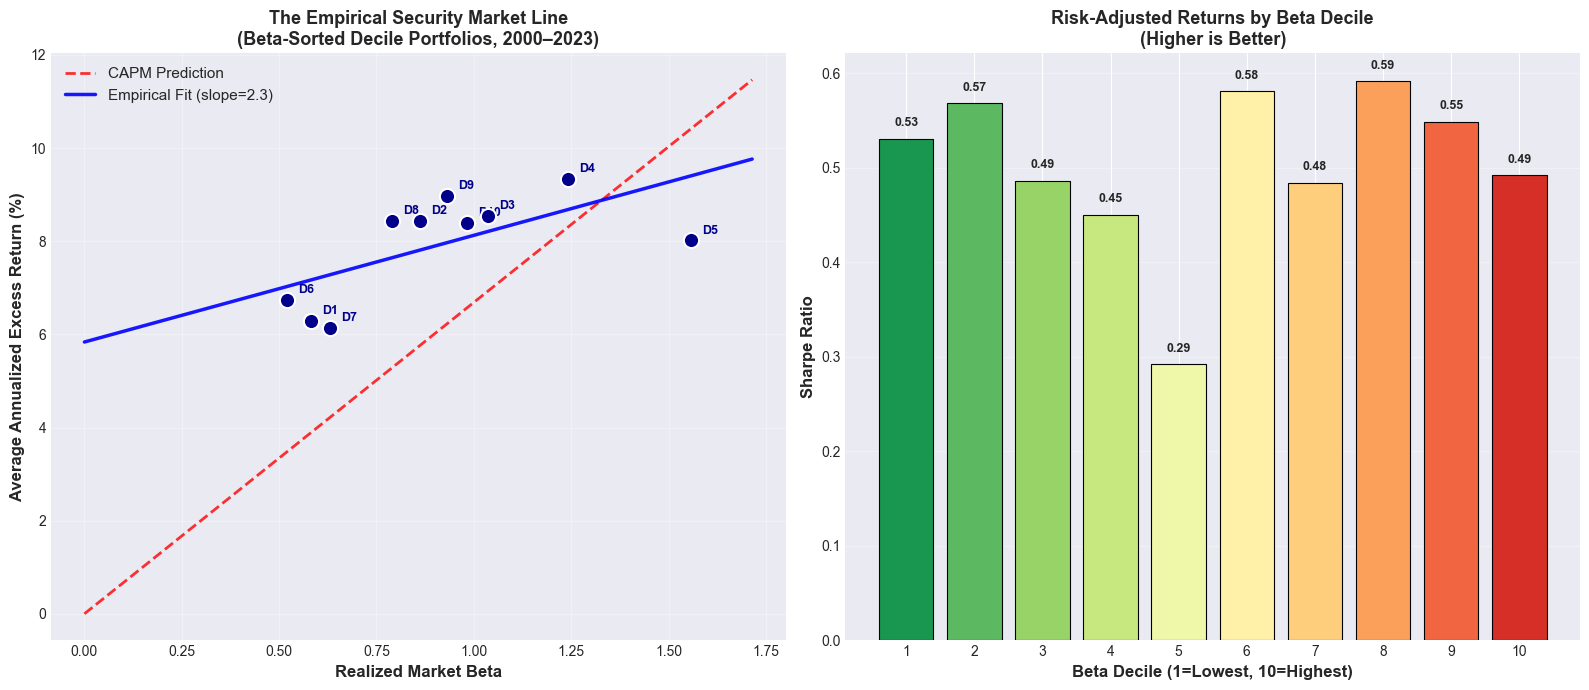


SIMPLE BAB FACTOR: LONG LOW-BETA (D1) − SHORT HIGH-BETA (D10)

  Simple (D1 − D10):
    Ann. Return:     -2.11%
    Ann. Vol:        11.21%
    Sharpe Ratio:    -0.19
    t-statistic:     -0.92
    Max Drawdown:    -62.5%

  Leveraged (FP-style):
    Ann. Return:      2.23%
    Ann. Vol:        13.44%
    Sharpe Ratio:     0.17
    t-statistic:      0.81
    Max Drawdown:    -41.9%

DOES BAB HAVE ALPHA AFTER FF5 + MOMENTUM?

Factor         Coef   t-stat   p-value
--------------------------------------
Alpha       -0.0014    -0.74    0.4566
Mkt_RF       0.2091     2.89    0.0038
SMB         -0.3179    -4.06    0.0000
HML         -0.1363    -1.03    0.3039
RMW          0.3020     3.05    0.0023
CMA          0.6392     3.96    0.0001
UMD          0.0420     0.65    0.5152

R² = 0.237
Alpha (annualized) = -1.74%


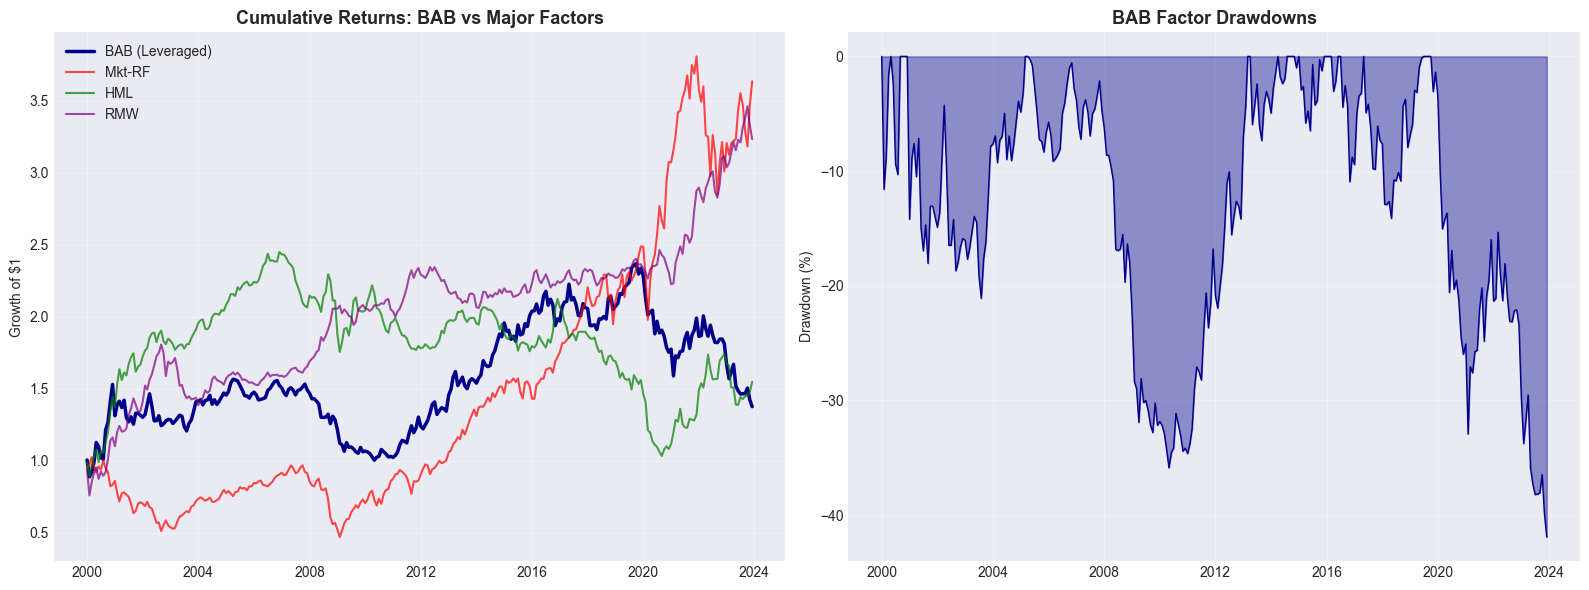


KEY FINDINGS:
1. The empirical SML is MUCH FLATTER than the CAPM predicts. Low-beta stocks 
   earn nearly as much (or more) than high-beta stocks — despite taking less 
   market risk.

2. On a RISK-ADJUSTED basis (Sharpe ratio), low-beta deciles dominate. This 
   is the core of the beta anomaly.

3. A simple BAB factor (long low-beta, short high-beta) earns positive returns,
   but whether it survives after FF5 + Momentum controls is an empirical 
   question — much of the BAB alpha may be explained by value (HML) and 
   profitability (RMW) loadings.

4. IMPLEMENTATION CHALLENGE: As Novy-Marx & Velikov (2022) emphasize, BAB 
   profits are concentrated in micro-caps and disappear under realistic trading 
   costs. This is a strategy that works beautifully on paper but is hard to 
   capture in practice.



In [6]:
# ============================================================================
# The Beta Anomaly: Empirical Security Market Line
# ============================================================================

print("="*70)
print("THE BETA ANOMALY — FLAT SECURITY MARKET LINE")
print("="*70)

# ---- Download beta-sorted decile portfolios from Ken French ----
# This file contains monthly returns for 10 portfolios sorted by pre-ranking
# market beta. We'll use value-weighted returns.

def download_beta_portfolios():
    """Download beta-sorted DECILE portfolio returns from Ken French's library.
    
    The 'Portfolios_Formed_on_BETA' file contains multiple sections
    (quintile and decile, value-weighted and equal-weighted, monthly and
    annual). We extract the first section that has 10 data columns —
    the value-weighted monthly decile returns.
    """
    import re, tempfile, urllib.request, zipfile, os
    from io import StringIO
    
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_BETA_CSV.zip"
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = f"{tmpdir}/data.zip"
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(tmpdir)
        files = [f for f in os.listdir(tmpdir) if f.lower().endswith('.csv')]
        csv_path = f"{tmpdir}/{files[0]}"

        with open(csv_path, 'r') as f:
            raw_lines = f.readlines()

    # ---- Parse ALL consecutive blocks of YYYYMM data rows ----
    # The file has multiple sections (quintile VW, quintile EW, decile VW,
    # decile EW, ...) separated by header/blank lines. We collect each
    # contiguous run of YYYYMM rows, then pick the first with 10 columns.
    sections = []
    current_block = []
    
    for line in raw_lines:
        stripped = line.strip()
        if re.match(r'^\s*\d{6}', stripped):
            current_block.append(stripped)
        else:
            if current_block:
                sections.append(current_block)
                current_block = []
    if current_block:
        sections.append(current_block)

    # Find the first block with ≥10 data columns (decile portfolios).
    # Quintile blocks have ~5 data columns; decile blocks have ~10.
    target = None
    for block in sections:
        sample = block[0]
        if ',' in sample:
            ncols = len(sample.split(',')) - 1   # minus the index column
        else:
            ncols = len(sample.split()) - 1
        if ncols >= 10:
            target = block
            break

    if target is None:
        col_counts = []
        for s in sections:
            if ',' in s[0]:
                col_counts.append(len(s[0].split(',')) - 1)
            else:
                col_counts.append(len(s[0].split()) - 1)
        raise ValueError(
            "Could not find a decile (10-portfolio) section in the French "
            f"beta file. Found {len(sections)} sections with column counts: "
            f"{col_counts}"
        )

    csv_text = '\n'.join(target)
    df = pd.read_csv(StringIO(csv_text), header=None, index_col=0)
    
    # Keep only the first 10 data columns and label them D1..D10
    df = df.iloc[:, :10]
    df.columns = [f'D{i+1}' for i in range(10)]
    
    df.index = pd.to_datetime(df.index.astype(str).str.strip(), format='%Y%m')
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    df = df / 100  # Convert percentages to decimals
    return df

print("Downloading beta-sorted decile portfolios from Ken French...")
beta_ports = download_beta_portfolios()

# Filter to our analysis period
beta_ports = beta_ports.loc['2000-01-01':'2023-12-31']
print(f"Beta-sorted decile portfolios: {beta_ports.shape[0]} months")
print(f"Deciles: D1 (lowest beta) through D10 (highest beta)\n")

# ---- Compute average excess returns and realized betas ----
rf_aligned = factors.loc[beta_ports.index, 'RF']
mkt_aligned = factors.loc[beta_ports.index, 'Mkt_RF']

avg_excess_returns = []
realized_betas = []
decile_labels = []

print(f"{'Decile':<10s} {'Avg Excess Ret (ann %)':>22s} {'Realized Beta':>14s} "
      f"{'Volatility (ann %)':>20s} {'Sharpe Ratio':>13s}")
print("-" * 82)

for col in beta_ports.columns:
    excess = beta_ports[col] - rf_aligned
    
    # Realized beta from regression on market
    X = sm.add_constant(mkt_aligned.values)
    res = sm.OLS(excess.values, X).fit()
    beta_hat = res.params[1]
    
    ann_ret = excess.mean() * 12 * 100
    ann_vol = excess.std() * np.sqrt(12) * 100
    sharpe = excess.mean() / excess.std() * np.sqrt(12)
    
    avg_excess_returns.append(ann_ret)
    realized_betas.append(beta_hat)
    decile_labels.append(col)
    
    print(f"{col:<10s} {ann_ret:22.2f} {beta_hat:14.2f} {ann_vol:20.2f} {sharpe:13.2f}")

avg_excess_returns = np.array(avg_excess_returns)
realized_betas = np.array(realized_betas)

# ---- The Punchline: Plot the Empirical SML ----
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left panel: Empirical SML vs CAPM prediction
ax = axes[0]
ax.scatter(realized_betas, avg_excess_returns, s=120, c='darkblue', zorder=5,
           edgecolors='white', linewidth=1.5)

for i, label in enumerate(decile_labels):
    ax.annotate(label, (realized_betas[i], avg_excess_returns[i]),
                textcoords="offset points", xytext=(8, 5), fontsize=9,
                fontweight='bold', color='darkblue')

# Theoretical CAPM line: passes through (0, 0) and (1, market premium)
mkt_premium_ann = mkt_aligned.mean() * 12 * 100
beta_range = np.linspace(0, max(realized_betas) * 1.1, 100)
capm_line = beta_range * mkt_premium_ann
ax.plot(beta_range, capm_line, 'r--', linewidth=2, label='CAPM Prediction',
        alpha=0.8)

# Best-fit line through the data
slope, intercept = np.polyfit(realized_betas, avg_excess_returns, 1)
fit_line = slope * beta_range + intercept
ax.plot(beta_range, fit_line, 'b-', linewidth=2.5,
        label=f'Empirical Fit (slope={slope:.1f})', alpha=0.9)

ax.set_xlabel('Realized Market Beta', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Annualized Excess Return (%)', fontsize=12, fontweight='bold')
ax.set_title('The Empirical Security Market Line\n(Beta-Sorted Decile Portfolios, 2000–2023)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

# Right panel: Sharpe ratio by decile
ax = axes[1]
sharpe_ratios = []
for col in beta_ports.columns:
    excess = beta_ports[col] - rf_aligned
    sharpe_ratios.append(excess.mean() / excess.std() * np.sqrt(12))

colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, 10))
bars = ax.bar(range(1, 11), sharpe_ratios, color=colors, edgecolor='black',
              linewidth=0.8)
ax.set_xlabel('Beta Decile (1=Lowest, 10=Highest)', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Risk-Adjusted Returns by Beta Decile\n(Higher is Better)',
             fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 11))
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, sr in zip(bars, sharpe_ratios):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{sr:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('beta_anomaly_sml.png', dpi=100, bbox_inches='tight')
plt.show()

# ---- Construct a simple BAB-like factor ----
print("\n" + "="*70)
print("SIMPLE BAB FACTOR: LONG LOW-BETA (D1) − SHORT HIGH-BETA (D10)")
print("="*70)

bab_simple = (beta_ports['D1'] - rf_aligned) - (beta_ports['D10'] - rf_aligned)
# More properly: BAB = (1/beta_low)(D1 - RF) - (1/beta_high)(D10 - RF)
# but for illustration the simple spread is instructive

# Also compute a leveraged version (Frazzini-Pedersen style)
beta_low = realized_betas[0]   # beta of decile 1
beta_high = realized_betas[-1]  # beta of decile 10
bab_leveraged = (1 / beta_low) * (beta_ports['D1'] - rf_aligned) \
              - (1 / beta_high) * (beta_ports['D10'] - rf_aligned)

for name, ret in [('Simple (D1 − D10)', bab_simple), 
                   ('Leveraged (FP-style)', bab_leveraged)]:
    ann_ret = ret.mean() * 12 * 100
    ann_vol = ret.std() * np.sqrt(12) * 100
    sharpe = ret.mean() / ret.std() * np.sqrt(12)
    tstat = ret.mean() / (ret.std() / np.sqrt(len(ret)))
    cum = (1 + ret).cumprod()
    maxdd = (cum / cum.cummax() - 1).min() * 100
    print(f"\n  {name}:")
    print(f"    Ann. Return:   {ann_ret:7.2f}%")
    print(f"    Ann. Vol:      {ann_vol:7.2f}%")
    print(f"    Sharpe Ratio:  {sharpe:7.2f}")
    print(f"    t-statistic:   {tstat:7.2f}")
    print(f"    Max Drawdown:  {maxdd:7.1f}%")

# ---- Alpha test: regress BAB on FF5 + Momentum ----
print("\n" + "="*70)
print("DOES BAB HAVE ALPHA AFTER FF5 + MOMENTUM?")
print("="*70)

bab_aligned = bab_leveraged.loc[factors.index].dropna()
ff_aligned = factors.loc[bab_aligned.index, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']]

X_ff = sm.add_constant(ff_aligned.values)
res_bab = sm.OLS(bab_aligned.values, X_ff).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6}
)

coef_names = ['Alpha'] + list(ff_aligned.columns)
print(f"\n{'Factor':<10s} {'Coef':>8s} {'t-stat':>8s} {'p-value':>9s}")
print("-" * 38)
for i, name in enumerate(coef_names):
    print(f"{name:<10s} {res_bab.params[i]:8.4f} {res_bab.tvalues[i]:8.2f} "
          f"{res_bab.pvalues[i]:9.4f}")
print(f"\nR² = {res_bab.rsquared:.3f}")
print(f"Alpha (annualized) = {res_bab.params[0] * 12 * 100:.2f}%")

# ---- Cumulative BAB vs individual factors ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
cum_bab = (1 + bab_leveraged).cumprod()
cum_mkt = (1 + factors['Mkt_RF']).cumprod()
cum_hml = (1 + factors['HML']).cumprod()
cum_rmw = (1 + factors['RMW']).cumprod()

ax.plot(cum_bab.index, cum_bab, linewidth=2.5, label='BAB (Leveraged)', color='darkblue')
ax.plot(cum_mkt.index, cum_mkt, linewidth=1.5, label='Mkt-RF', color='red', alpha=0.7)
ax.plot(cum_hml.index, cum_hml, linewidth=1.5, label='HML', color='green', alpha=0.7)
ax.plot(cum_rmw.index, cum_rmw, linewidth=1.5, label='RMW', color='purple', alpha=0.7)
ax.set_title('Cumulative Returns: BAB vs Major Factors', fontsize=13, fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Drawdown of BAB
ax = axes[1]
dd_bab = (cum_bab / cum_bab.cummax() - 1) * 100
ax.fill_between(dd_bab.index, dd_bab, 0, alpha=0.4, color='darkblue')
ax.plot(dd_bab.index, dd_bab, linewidth=1, color='darkblue')
ax.set_title('BAB Factor Drawdowns', fontsize=13, fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bab_factor_performance.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY FINDINGS:
1. The empirical SML is MUCH FLATTER than the CAPM predicts. Low-beta stocks 
   earn nearly as much (or more) than high-beta stocks — despite taking less 
   market risk.

2. On a RISK-ADJUSTED basis (Sharpe ratio), low-beta deciles dominate. This 
   is the core of the beta anomaly.

3. A simple BAB factor (long low-beta, short high-beta) earns positive returns,
   but whether it survives after FF5 + Momentum controls is an empirical 
   question — much of the BAB alpha may be explained by value (HML) and 
   profitability (RMW) loadings.

4. IMPLEMENTATION CHALLENGE: As Novy-Marx & Velikov (2022) emphasize, BAB 
   profits are concentrated in micro-caps and disappear under realistic trading 
   costs. This is a strategy that works beautifully on paper but is hard to 
   capture in practice.
""")

---

## Section 6: Recent Research — The Frontier of Factor Investing

### 6.1 Andrew Chen & Tom Zimmermann — "Open Source Cross-Sectional Asset Pricing" (2022)

Chen and Zimmermann replicated **over 200 published cross-sectional return predictors** using standardized methodology. Their findings are sobering:

**Key Results:**
- Of 200+ published anomalies, roughly **half fail to replicate** using post-publication data
- Many anomalies have substantially weaker effects than originally reported (publication bias)
- **The strongest, most replicable factors** tend to be: market, value, momentum, profitability, investment, and short-term reversal
- After accounting for multiple testing and publication bias, the "zoo of factors" shrinks dramatically

**Why This Matters:**
- Not all published factors are real — many are likely data-mined
- The Fama-French factors (Mkt, SMB, HML, RMW, CMA) are among the most robust
- Momentum (UMD) also replicates well
- Investors should be skeptical of exotic factors with narrow sample periods

Their dataset and code are publicly available (openassetpricing.com), making it a landmark contribution to reproducible research.

### 6.2 Wei Dai (Dimensional Fund Advisors) — Factor Premia in Practice

Wei Dai, head of research at Dimensional Fund Advisors, has published extensively on:

**"Premiums for the Long Run" (Dai, 2022):**
- Examines how long investors must hold factor-tilted portfolios before they can reasonably expect to realize the premium
- Found that even with statistically significant premia, investors often need **10–15+ years** to have a high probability (>80%) of outperforming the market
- The probability of outperforming increases with horizon, but there are meaningful multi-year stretches of underperformance

**"How Should Investors Set Return Expectations?" (Dai & Medhat, 2023):**
- Argues that sample averages of historical returns are poor predictors of future premia
- Advocates using cross-sectional valuation spreads (the current cheapness of value relative to growth, for example) as better signals
- When value spreads are wide (cheap stocks are very cheap), expected value premia are higher

**"What Drives Factor Premia?" (Dai et al., 2024):**
- Shows that **realized factor premia are time-varying** and depend on changes in valuation ratios
- Decomposition: Factor return = Change in valuation spread + cash-flow premium
- In the long run, the cash-flow component dominates — but shorter-horizon returns are dominated by re-valuations (i.e., whether the spread compresses or widens)

**Key Insights for Practitioners:**
- Factor investing requires patience — multi-year tracking error vs. the market is normal
- Valuation spreads are informative about expected premia
- The premium is not "timing the factor" — it's about being well-diversified across known return dimensions

### 6.3 Robert Novy-Marx & Mihail Velikov — Transaction Costs and Factor Implementability

Novy-Marx and Velikov have been among the sharpest critics of the "factor zoo," focusing on which factors are actually **implementable after costs**:

**"A Taxonomy of Anomalies and Their Trading Costs" (Novy-Marx & Velikov, 2016):**
- Many anomalies that appear profitable in academic backtests **disappear after trading costs**
- High-turnover strategies (like short-term reversal) are particularly vulnerable
- Low-turnover strategies (value, profitability, investment) survive costs much better

**"Betting Against Betting Against Beta" (Novy-Marx & Velikov, 2022):**
- Critiqued the popular "Betting Against Beta" (BAB) factor introduced by Frazzini and Pedersen
- Showed that BAB profits are largely concentrated in difficult-to-trade micro-cap stocks
- After realistic trading costs and size exclusions, BAB profits are much weaker

**"Assaying Anomalies" (Novy-Marx & Velikov, 2023):**
- Systematic evaluation of which anomalies survive implementability tests
- **Robust survivors**: value, profitability, momentum (with smart implementation)
- **Casualties**: many short-term trading signals, exotic anomalies, and factors concentrated in micro-caps

**Practical Takeaway**: The gap between academic factor returns and implementable factor returns is **large**. Factors that require trading small, illiquid stocks or high-frequency rebalancing lose much of their premium to costs. This favors strategies used by firms like Dimensional and Avantis, which focus on broadly diversified, low-turnover factor tilts.

### 6.4 The q-Factor Model (Hou, Xue, and Zhang, 2015, 2021)

An alternative to the Fama-French framework from a different theoretical perspective:

$$R_i - R_f = \alpha + \beta_{MKT}(R_m - R_f) + \beta_{ME} \cdot r_{ME} + \beta_{ROE} \cdot r_{ROE} + \beta_{I/A} \cdot r_{I/A} + \epsilon$$

- $r_{ME}$: Size factor (similar to SMB)
- $r_{ROE}$: Profitability factor based on return on equity (similar to RMW)
- $r_{I/A}$: Investment factor (similar to CMA)

The q-factor model is motivated by a **production-based** (supply-side) asset pricing theory rather than the consumption-based (demand-side) arguments of traditional CAPM. It has similar empirical performance to FF5 and subsumes many anomalies.

### 6.5 Cliff Asness (AQR) — Value vs. Growth: The Long View

Asness has written extensively about the value factor's challenges and recovery:

**"Value & Momentum Everywhere" (Asness, Moskowitz, Pedersen, 2013):**
- Showed that value and momentum premia exist across asset classes (stocks, bonds, currencies, commodities), not just equities
- Provides strong evidence that these are not data-mined US-specific phenomena

**On the Value Drawdown (2020–2022):**
- The value factor experienced its worst drawdown in history from ~2018–2020
- Asness argued this was driven by extreme "momentum-fueled growth speculation" rather than a fundamental change in the value premium
- His prediction proved correct: value had a dramatic recovery in 2021–2022

In [ ]:
# ============================================================================
# Research Deep Dive: Factor Performance Across Decades
# ============================================================================

print("="*70)
print("FACTOR PERFORMANCE BY DECADE")
print("="*70)

factor_cols_all = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

# Define sub-periods
periods = {
    '2000-2004': ('2000-01-01', '2004-12-31'),
    '2005-2009': ('2005-01-01', '2009-12-31'),
    '2010-2014': ('2010-01-01', '2014-12-31'),
    '2015-2019': ('2015-01-01', '2019-12-31'),
    '2020-2023': ('2020-01-01', '2023-12-31'),
}

decade_returns = {}
for period_name, (start, end) in periods.items():
    sub = factors.loc[start:end, factor_cols_all]
    ann_ret = sub.mean() * 12 * 100  # Annualized, in %
    decade_returns[period_name] = ann_ret

decade_df = pd.DataFrame(decade_returns).T
print("\nAnnualized Returns by Sub-Period (%):")
print(decade_df.round(2))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Heatmap of factor returns by period
ax = axes[0]
sns.heatmap(decade_df, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            ax=ax, linewidths=0.5, cbar_kws={'label': 'Annualized Return (%)'})
ax.set_title('Factor Returns by Sub-Period (%)\n'
             'Green = positive return, Red = negative return', fontweight='bold', fontsize=12)
ax.set_ylabel('')

# Plot 2: Value spread proxy — rolling HML cumulative return
ax = axes[1]
# Show the value factor's "death and resurrection"
hml_cum = (1 + factors['HML']).cumprod()
ax.plot(factors.index, hml_cum, color='purple', linewidth=2, label='HML Cumulative')
ax.set_title('The Value Factor: Drawdown and Recovery (2000–2023)', fontweight='bold', fontsize=12)
ax.set_ylabel('Growth of $1')
ax.grid(True, alpha=0.3)

# Annotate key periods
ax.axvspan('2018-01-01', '2020-09-01', alpha=0.15, color='red', label='Value drawdown')
ax.axvspan('2020-10-01', '2022-12-31', alpha=0.15, color='green', label='Value recovery')
ax.legend()

plt.tight_layout()
plt.savefig('factor_decades.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
DISCUSSION:
1. Factor premia are NOT constant — they vary substantially across periods
2. The value factor (HML) had negative returns in 2015-2019 and recovered 
   strongly in 2020-2023. This is the "value drawdown" that shook many 
   investors' confidence.
3. Momentum (UMD) experienced its crash during the GFC recovery (2009) 
   but has otherwise been strong.
4. Profitability (RMW) has been relatively consistent — this is one reason 
   it has gained popularity among factor investors.
5. These sub-period variations are exactly why Wei Dai emphasizes the need 
   for LONG HORIZONS when evaluating factor strategies.
""")

In [ ]:
# ============================================================================
# The "Kitchen Sink" Model: 5 Factors + Momentum on Our ETFs
# ============================================================================

print("="*70)
print("COMPREHENSIVE MODEL: FF5 + MOMENTUM")
print("="*70)
print("\nAdding UMD to the 5-factor model gives us the most complete")
print("specification. Let's see how each ETF maps onto all six factors.\n")

full_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
full_names = ['Alpha', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

all_params = {}
all_pvals = {}
all_r2 = {}

for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]
    res = run_ff_regression(None, full_cols, edf, stock_name=label)
    all_params[ticker] = res.params
    all_pvals[ticker] = res.pvalues
    all_r2[ticker] = res.rsquared

    print(f"\n{label}")
    print("-" * 60)
    for i, name in enumerate(full_names):
        sig = '***' if res.pvalues[i] < 0.01 else ('**' if res.pvalues[i] < 0.05 else ('*' if res.pvalues[i] < 0.10 else ''))
        print(f"  {name:10s} = {res.params[i]:9.5f}  (t={res.tvalues[i]:6.2f}, p={res.pvalues[i]:.4f}) {sig}")
    print(f"  R² = {res.rsquared:.4f}   Adj R² = {res.rsquared_adj:.4f}")

# Visualization: Factor loadings comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(full_names) - 1)  # Exclude alpha for visualization
width = 0.25

for i, (ticker, label) in enumerate(etf_tickers.items()):
    params_no_alpha = all_params[ticker][1:]  # Skip alpha
    bars = ax.bar(x + i * width, params_no_alpha, width, label=label, alpha=0.8)
    # Add significance markers
    for j, bar in enumerate(bars):
        p = all_pvals[ticker][j + 1]
        if p < 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    '***', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Factor')
ax.set_ylabel('Factor Loading (β)')
ax.set_title('Factor Loadings: FF5 + Momentum\n(*** = significant at 1% level, Newey-West SEs)',
             fontweight='bold', fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(full_names[1:])
ax.axhline(0, color='black', linewidth=0.5)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('full_model_loadings.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
INTERPRETATION GUIDE:
- Bar height = factor sensitivity (positive = tilts toward that factor)
- *** = statistically significant at 1% level
- SPY should be dominated by Mkt_RF ≈ 1, everything else near zero
- IWN should show positive SMB, positive HML, and possibly negative UMD
- VTV should show positive HML, possibly positive RMW
""")

---

## Section 7: Practical Implications — Dimensional, Avantis, and the Rational Reminder Perspective

> **Note (February 2026):** The practitioner details below — specific ETF tickers, expense ratios, podcast references, and firm descriptions — reflect the landscape as of early 2026. Fund offerings and fee structures change over time; verify current details before making investment decisions.

### 7.1 Dimensional Fund Advisors (DFA)

Dimensional is the original "factor investing" firm, founded in 1981 by David Booth and Rex Sinquefield with direct guidance from Eugene Fama and Kenneth French (who serve as consultants/board members).

**Investment Philosophy:**
- Markets are broadly efficient — don't try to pick stocks or time the market
- Academic research identifies **reliable dimensions of higher expected returns**: market, size, value, and profitability
- **Systematically tilt** portfolios toward small-cap, value, and profitable stocks
- Use **patient, low-cost trading** — don't track an index mechanically, but trade opportunistically to minimize costs
- **Broad diversification** within the tilt — hold thousands of stocks, not concentrated bets

**Key Implementation Details:**
- **No hard rebalancing dates** — unlike index funds that must buy/sell on reconstitution dates. DFA trades patiently using "daily rebalancing ranges"
- **Integrated approach** — simultaneously sort on value, size, AND profitability. A stock is attractive if it scores well on multiple dimensions, not just one
- **Momentum as an exclusion screen** — DFA doesn't buy momentum per se but avoids buying stocks with negative momentum (delays buying value stocks that are still falling). This is the "anti-momentum crash" approach.
- **Direct indexing at scale** — portfolios of 8,000–12,000 stocks with factor tilts

**What Does DFA Tilt Toward?**
- Positive SMB (small-cap overweight)
- Positive HML (value overweight)
- Positive RMW (profitability overweight)
- Near-zero or slightly positive UMD (via momentum exclusion, not direct momentum trading)

### 7.2 Avantis Investors

Avantis was founded in 2019 by former Dimensional employees (led by Eduardo Repetto, DFA's former CIO). Their approach is similar in spirit but with some refinements:

**Key Differences from DFA:**
- **Available as standard ETFs** — DFA traditionally required advisory relationships; Avantis launched as publicly traded ETFs from day one
- **More emphasis on expected returns** — Avantis ranks stocks by expected return (combining current valuation and profitability metrics) rather than sorting independently on each dimension
- **Slightly more concentrated** — Avantis may overweight their highest-conviction positions more aggressively than DFA
- **Lower expense ratios** — competitive pricing (often 0.15–0.25% for core strategies)

**Avantis' Factor Implementation:**
- Uses a "composite expected return" measure combining book-to-market (value) and cash-flow profitability
- Overweights stocks that are both cheap AND profitable — capturing the interaction effect documented by Novy-Marx
- Also uses momentum as a timing signal for implementation

**Notable Avantis ETFs:**
- AVUV (US Small Cap Value) — one of the most popular factor ETFs
- AVDV (International Small Cap Value)
- AVES (Emerging Markets Value)

### 7.3 The Rational Reminder Perspective

The Rational Reminder podcast (Ben Felix and Cameron Passmore) has become one of the most influential voices in evidence-based investing. Their perspective synthesizes academic research for practitioner audiences:

**Core Tenets:**
1. **Factor premia are compensation for risk** — not free money. Investors must be willing to underperform the market for extended periods.
2. **Implementation matters enormously** — the gap between theoretical factor returns and what investors actually earn can be large (Novy-Marx & Velikov's work)
3. **Combining factors is better than concentrating** — value + profitability + momentum integration reduces drawdowns
4. **Discipline is the hardest part** — many investors abandon factor strategies during drawdowns (e.g., value's terrible 2018–2020), which is precisely when expected premia are highest
5. **Small-cap value with profitability screening** is the most evidence-supported active tilt for equity investors
6. **Global diversification** across regions enhances factor exposure reliability

**Ben Felix's "Five Factor Investing with ETFs" Framework:**
- Core market exposure (e.g., VT, XEQT)
- Small-cap value tilt (e.g., AVUV, AVDV)
- Screen for profitability within the value tilt
- Rebalance systematically
- Maintain the allocation through good times and bad

**Key Topics from Rational Reminder Episodes:**
- *Factor investing vs. stock picking* — factors explain most of the variation in returns across portfolios
- *The persistence of premia after publication* — McLean & Pontiff (2016) showed post-publication decay of ~35% on average, but the strongest factors survive
- *Is value dead?* — No. Asness, Dai, and others have shown that value's poor performance was driven by spread expansion (growth getting more expensive relative to value), not a fundamental change. When spreads revert, value recovers.
- *Expected returns vs. realized returns* — Realized returns over short periods are dominated by valuation changes, not differences in expected returns. This is why factor investing requires patience.

### 7.4 The Factor Investing Decision Matrix

| Question | Answer | Implication |
|----------|--------|-------------|
| Do factors exist? | Yes — strong academic evidence for market, value, size, profitability, momentum | These are real phenomena, not data mining |
| Are they persistent? | Yes — across time periods, countries, and asset classes | Unlikely to be sample-specific artifacts |
| Are they robust? | Mostly — value, profitability, and momentum survive trading costs; many exotic factors do not | Focus on the "big five" (or six, with momentum) |
| Are they risk or mispricing? | Debated — probably a mix. Value and profitability have risk-based stories; momentum is harder to explain as risk | Both interpretations support the premium persisting |
| Can you capture them? | Yes — but implementation quality matters a lot | Use well-designed products (DFA, Avantis, or similar) |
| How long must you wait? | 10–20+ years for high confidence | This is a lifetime commitment, not a trade |
| What's the biggest risk? | Behavioral — giving up during a drawdown | Understand tracking error before you start |

In [ ]:
# ============================================================================
# Practical Analysis: Factor Diversification and Risk
# ============================================================================

print("="*70)
print("THE CASE FOR MULTI-FACTOR DIVERSIFICATION")
print("="*70)

# Build simple factor portfolios
factor_cols_invest = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'UMD']

# Equal-weight combination of all style factors (excluding market)
style_factors = ['SMB', 'HML', 'RMW', 'CMA', 'UMD']
factors['EqualWeight_Styles'] = factors[style_factors].mean(axis=1)

# Value + Profitability combo (Dimensional/Avantis approach)
factors['Value_Profit'] = (factors['HML'] + factors['RMW']) / 2

# Value + Profitability + Momentum (full integration)
factors['Value_Profit_Mom'] = (factors['HML'] + factors['RMW'] + factors['UMD']) / 3

# Performance comparison
strategies = {
    'HML only (Value)': factors['HML'],
    'RMW only (Profitability)': factors['RMW'],
    'UMD only (Momentum)': factors['UMD'],
    'Value + Profitability': factors['Value_Profit'],
    'Value + Profit + Mom': factors['Value_Profit_Mom'],
    'Equal-Weight All Styles': factors['EqualWeight_Styles'],
}

print(f"\n{'Strategy':<28s} {'Ann Ret':>8s} {'Ann Vol':>8s} {'Sharpe':>7s} {'MaxDD':>7s} {'Skew':>6s}")
print("-" * 72)

for name, ret_series in strategies.items():
    ann_ret = ret_series.mean() * 12 * 100
    ann_vol = ret_series.std() * np.sqrt(12) * 100
    sharpe = ret_series.mean() / ret_series.std() * np.sqrt(12)
    cum = (1 + ret_series).cumprod()
    drawdown = (cum / cum.cummax() - 1).min() * 100
    skew = ret_series.skew()
    print(f"{name:<28s} {ann_ret:8.2f} {ann_vol:8.2f} {sharpe:7.2f} {drawdown:7.1f} {skew:6.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative returns of single vs combined strategies
ax = axes[0, 0]
for name, ret_series in strategies.items():
    cum = (1 + ret_series).cumprod()
    lw = 2.5 if 'Value + Profit' in name else 1.2
    ls = '-' if '+' in name or 'Equal' in name else '--'
    ax.plot(factors.index, cum, label=name, linewidth=lw, linestyle=ls)
ax.set_title('Single Factors vs Combined Strategies', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=7, loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Drawdown comparison
ax = axes[0, 1]
for name in ['HML only (Value)', 'UMD only (Momentum)', 'Value + Profit + Mom']:
    cum = (1 + strategies[name]).cumprod()
    dd = (cum / cum.cummax() - 1) * 100
    ax.plot(factors.index, dd, label=name, linewidth=1.5)
ax.set_title('Drawdowns: Diversification Reduces Pain', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Rolling 36-month returns
ax = axes[1, 0]
for name in ['HML only (Value)', 'RMW only (Profitability)', 'Value + Profit + Mom']:
    rolling = strategies[name].rolling(36).mean() * 1200
    ax.plot(factors.index, rolling, label=name, linewidth=1.5)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('Rolling 3-Year Annualized Returns', fontweight='bold')
ax.set_ylabel('Annualized Return (%)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Distribution comparison
ax = axes[1, 1]
for name, color in [('HML only (Value)', 'purple'),
                     ('UMD only (Momentum)', 'red'),
                     ('Value + Profit + Mom', 'black')]:
    ax.hist(strategies[name] * 100, bins=40, alpha=0.4, color=color,
            label=name, density=True)
ax.set_title('Return Distributions', fontweight='bold')
ax.set_xlabel('Monthly Return (%)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('multifactor_diversification.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY TAKEAWAYS:
1. COMBINING factors significantly improves the Sharpe ratio and reduces 
   maximum drawdown compared to any single factor.

2. Value + Profitability is the "Dimensional/Avantis sweet spot" — these 
   factors are negatively correlated, so they naturally hedge each other.

3. Adding Momentum further improves the combination because momentum is 
   negatively correlated with value (winners tend to be growth stocks, 
   losers tend to be value stocks).

4. The equal-weight combination has the LOWEST SKEWNESS risk — no single 
   factor's crash dominates the portfolio.

5. This is the empirical foundation for why evidence-based investors like 
   those on Rational Reminder advocate multi-factor diversification rather 
   than single-factor bets.
""")

---

## Section 8: Rolling-Window Analysis — Time-Varying Factor Exposures

### Why Rolling Windows?

The regressions so far estimate **constant** factor loadings over the full sample. But in reality, a fund's factor exposures can change over time due to:
- Changes in the index methodology or fund holdings
- Market regime shifts (e.g., value rotation vs. growth dominance)
- Varying sector composition within size/value groups

Rolling-window regressions fit the model over a moving window (e.g., 36 months) and let us see how betas evolve. This is a powerful diagnostic tool and is used extensively by practitioners.

> **Why plain OLS inside each window?** In the 3-Factor tutorial we used Newey-West standard errors to account for autocorrelation over the full 168-month sample. Inside each 36-month rolling window, the primary goal is estimating the *point estimates* (betas), not conducting hypothesis tests. OLS point estimates are unbiased regardless of the error structure, so Newey-West would change only the standard errors, not the estimated betas. Moreover, with only 36 observations the Newey-West long-run variance estimate becomes unreliable (few lags, few observations per lag). For these reasons, practitioners typically use plain OLS inside rolling windows and reserve HAC corrections for the full-sample inference.

In [ ]:
# ============================================================================
# Rolling-Window 5-Factor + Momentum Regressions
# ============================================================================

window = 36  # 36-month rolling window

print("="*70)
print(f"ROLLING {window}-MONTH FACTOR REGRESSIONS")
print("="*70)

roll_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
roll_names = ['Alpha', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

fig, axes = plt.subplots(len(etf_tickers), len(roll_names), figsize=(24, 12),
                          sharex=True)

for row, (ticker, label) in enumerate(etf_tickers.items()):
    edf = etf_dataframes[ticker]
    n = len(edf)

    # Store rolling betas
    rolling_betas = {name: [] for name in roll_names}
    dates = []

    for i in range(window, n):
        window_data = edf.iloc[i - window:i]
        y_w = window_data['Stock_Excess_Return'].values
        X_w = sm.add_constant(window_data[roll_cols].values)
        try:
            res_w = sm.OLS(y_w, X_w).fit()
            for j, name in enumerate(roll_names):
                rolling_betas[name].append(res_w.params[j])
            dates.append(edf.index[i])
        except:
            for name in roll_names:
                rolling_betas[name].append(np.nan)
            dates.append(edf.index[i])

    # Plot each coefficient
    for col, name in enumerate(roll_names):
        ax = axes[row, col]
        ax.plot(dates, rolling_betas[name], linewidth=1.2, color='darkblue')
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
        ax.set_title(f'{ticker}: {name}', fontsize=9, fontweight='bold')
        ax.grid(True, alpha=0.3)
        if col == 0:
            ax.set_ylabel(label.split('(')[0].strip(), fontsize=8)
        ax.tick_params(axis='both', labelsize=7)

plt.suptitle(f'Rolling {window}-Month Factor Loadings (OLS)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('rolling_betas.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
WHAT TO LOOK FOR:
- SPY: Mkt_RF should be stable near 1.0; other betas should be near zero 
  throughout (confirming SPY is "pure market" exposure).
  
- IWN: SMB and HML should be consistently positive (confirming small-value 
  tilt). Watch for any drift over time.
  
- VTV: HML should be consistently positive. RMW may vary as the composition 
  of "value" stocks changes.

- Alpha: Should be close to zero for passive ETFs. Persistent positive alpha 
  would suggest the ETF adds value beyond its factor exposures.

- TIME VARIATION: If betas shift significantly, it means the fund's risk 
  profile is changing — important for portfolio construction.
""")

---

## Section 9: Summary and Further Reading

### What We've Learned

This notebook covered the major extensions and debates surrounding factor investing:

| Topic | Key Takeaway |
|-------|-------------|
| **FF5 Model** | Adding profitability (RMW) and investment (CMA) subsumes much of HML's alpha |
| **Carhart Momentum** | Momentum is the most robust anomaly but carries severe crash risk |
| **Novy-Marx Profitability** | Gross profitability is an independent predictor; combining it with value is powerful |
| **Short-Term Reversals** | 1-month reversal premium exists but high trading costs erode most of it |
| **Long-Term Reversals** | Closely related to value effect; stocks mean-revert over 3–5 years |
| **Beta Anomaly / BAB** | The empirical SML is flat or negative; low-beta stocks earn higher risk-adjusted returns than high-beta stocks. Implementation after costs is challenging. |
| **Chen & Zimmermann** | Many published anomalies fail to replicate; the core factors are robust |
| **Wei Dai / Dimensional** | Factor investing requires 10–20 year horizons; valuation spreads predict premia |
| **Novy-Marx & Velikov** | Implementation costs matter enormously; many anomalies vanish after trading costs |
| **DFA / Avantis** | Integrated multi-factor approaches (value + profitability + momentum screen) are the gold standard |
| **Rational Reminder** | Discipline is the biggest challenge; multi-factor diversification reduces behavioral risk |

### The Factor Model Hierarchy

```
Level 1: CAPM (1 factor)
   R_i - R_f = α + β_MKT(R_m - R_f) + ε
   
Level 2: Fama-French 3-Factor (1993)
   + SMB (size) + HML (value)
   
Level 3: Carhart 4-Factor (1997)
   + UMD (momentum)
   
Level 4: Fama-French 5-Factor (2015)
   + RMW (profitability) + CMA (investment)
   [note: momentum intentionally excluded by Fama-French]
   
Level 5: FF5 + Momentum (6-Factor, practitioner standard)
   The "kitchen sink" model used in much applied research
   
Alternative: q-Factor Model (Hou, Xue, Zhang)
   MKT + ME (size) + ROE (profitability) + I/A (investment)
   Motivated by production-based theory
```

### Essential Reading

**Foundational Papers:**
- Fama & French, "Common Risk Factors in the Returns on Stocks and Bonds" (1993)
- Fama & French, "A Five-Factor Asset Pricing Model" (2015)
- Carhart, "On Persistence in Mutual Fund Performance" (1997)
- Novy-Marx, "The Other Side of Value: The Gross Profitability Premium" (2013)
- Black, Jensen & Scholes, "The Capital Asset Pricing Model: Some Empirical Tests" (1972)
- Frazzini & Pedersen, "Betting Against Beta" (2014)

**Modern Research:**
- Chen & Zimmermann, "Open Source Cross-Sectional Asset Pricing" (2022)
- Novy-Marx & Velikov, "A Taxonomy of Anomalies and Their Trading Costs" (2016)
- Novy-Marx & Velikov, "Betting Against Betting Against Beta" (2022)
- Hou, Xue & Zhang, "Replicating Anomalies" (2020)
- Daniel & Moskowitz, "Momentum Crashes" (2016)
- Asness, Moskowitz & Pedersen, "Value and Momentum Everywhere" (2013)
- Cederburg & O'Doherty, "Does It Pay to Bet Against Beta?" (2016)
- Hong & Sraer, "Speculative Betas" (2016)

**Practitioner Research:**
- Wei Dai, "Premiums for the Long Run" (Dimensional, 2022)
- Turan Bali, Robert Engle & Scott Murray, *Empirical Asset Pricing: The Cross Section of Stock Returns* (2016)
- Andrew Ang, *Asset Management: A Systematic Approach to Factor Investing* (2014)
- Andrew Berkin & Larry Swedroe, *Your Complete Guide to Factor-Based Investing* (2016)

- Antti Ilmanen, *Expected Returns* (2011)

- Antti Ilmanen, *Expected Returns* (2011)- Antti Ilmanen, *Expected Returns* (2011)

**Books:**- Andrew Berkin & Larry Swedroe, *Your Complete Guide to Factor-Based Investing* (2016)
- Andrew Ang, *Asset Management: A Systematic Approach to Factor Investing* (2014)

---

## Exercises

Test your understanding of the advanced topics covered in this notebook.

### Exercise 1: 5-Factor Model on a New ETF (Hands-On)

Download return data for **IWM** (iShares Russell 2000 ETF — small-cap blend, no explicit value tilt) and run the full 5-factor regression.

1. How does IWM's SMB loading compare to IWN's? Is this what you expected?
2. Does IWM have a significant HML loading? Why or why not?
3. What happens to IWM's alpha when you move from 3 factors to 5 factors?

```python
# Starter code:
raw = yf.download('IWM', start='2000-01-01', end='2023-12-31', progress=False)
# ... compute monthly excess returns, then:
# res3 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML'], iwm_df)
# res5 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'], iwm_df)
```

### Exercise 2: Rolling Sharpe Ratios for Combined Strategies (Hands-On)

Using the multi-factor strategy returns computed in Section 7:

1. Compute the **rolling 36-month Sharpe ratio** for (a) HML alone, (b) Value + Profitability, and (c) Value + Profitability + Momentum.
2. Plot all three on the same chart. During which periods does the combined strategy most clearly outperform single factors?
3. Is there any period where all three strategies have a negative rolling Sharpe ratio simultaneously?

```python
# Starter code:
# rolling_sharpe = ret_series.rolling(36).mean() / ret_series.rolling(36).std() * np.sqrt(12)
```

### Exercise 3: Momentum Crash Anatomy (Discussion + Hands-On)

1. Identify the **worst 3-month period** for the momentum factor (UMD) in our sample. What calendar months were they?
2. What was the market (Mkt-RF) doing during those months? Was this consistent with the Daniel & Moskowitz (2016) narrative of momentum crashing during market recoveries?
3. If you had held an **equal-weight combination of UMD and HML**, how much would the drawdown have been reduced?

```python
# Starter code:
# rolling_3m_mom = factors['UMD'].rolling(3).sum()
# worst_end = rolling_3m_mom.idxmin()
# print(f"Worst 3-month period ending: {worst_end}")
```

### Exercise 4: The Beta Anomaly — Subsample Robustness (Discussion + Hands-On)

The beta anomaly (flat or negative SML) was documented in data going back to the 1930s. But does it hold in every subperiod?

1. Split the beta-sorted decile portfolios into two halves: 2000–2011 and 2012–2023. Plot the empirical SML for each subperiod. Is the anomaly consistent, or does it appear mainly in one era?
2. Regress the simple BAB factor (D1 − D10) on FF5 + Momentum separately for each subperiod. Does the alpha change sign or significance?
3. **Discussion**: Frazzini and Pedersen argue leverage constraints drive the BAB premium. Did anything change about leverage availability (e.g., the rise of leveraged ETFs, zero-commission brokers) between the two subperiods that might affect the premium?

```python
# Starter code:
# beta_first = beta_ports.loc['2000':'2011']
# beta_second = beta_ports.loc['2012':'2023']
# For each half, recompute avg excess returns and realized betas, then plot.
```